In [ ]:
!pip install requirements.txt

In [ ]:
# make sure to install appropriate PyTorch version
# https://pytorch.org/get-started/locally/
# Versions used to develop this notebook:
# torch                                    2.3.1+cu118
# torchaudio                               2.3.1+cu118
# torchvision                              0.18.1+cu118

In [124]:
import pandas as pd
import numpy as np
import torch 
from fredapi import Fred
import matplotlib.pyplot as plt
import yaml
import seaborn as sns
from pathlib import Path
import mlflow
import os
from torch import optim
import torch.nn as nn
from statsmodels.graphics.tsaplots import plot_acf
import warnings

In [125]:
warnings.filterwarnings("ignore")

### Forecasting monetary policy variables using deep learning and monetary policy theory.

In [4]:
# Pytorch settings
scaling_mode = "standard"
batch_size = 4
seq_length = 3
random_seed = 1
torch.manual_seed(random_seed)
log_interval = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_folder = Path("./models")
print(device)

cuda:0


In [339]:
# MLflow settings
uri = ""
mlflow.set_tracking_uri(uri)
# launch server using "mlflow server --host 127.0.0.1 --port 8080" in a terminal

### Central bank aims to minimize:
### $L_t = E_t\left[\frac{1}{2}(U_t - \tilde{U})^2 +  \frac{1}{2}\theta(\pi_t - \tilde{\pi})^2\right]$
### By choosing $U_t$ and $\pi_t$ such that $U_t = -(\pi_t - \pi^e_t)$.
### Where $U_t$ is unemployment, $\tilde{U}, \tilde{\pi}$ are socially optimal levels of unemployment and inflation, and $\pi^e$ are inflation expectations.
### Which we can use the fisher equation $r_t = i_t -\pi_t$ so that central banks can use $i$ to influence inflation and hence unemployment.
### With this, we will model these variables by just using unemployment, inflation, and Federal Funds Effective Rate.

### FRED data setup

In [20]:
%%writefile configs/time_series_config.yaml
FRED:
    CPIAUCSL:
        name: CPI
        log: false
        diff: true
        n_diffs: 1
        diff_name: log_inflation_MoM
    FEDFUNDS:
        name: fed_rate
        log: true
        diff: true
        n_diffs: 1
    UNRATE:
        name: Unemployment
        log: false
        diff: true
        n_diffs: 1

Overwriting configs/time_series_config.yaml


In [341]:
path = "./params"
os.makedirs(path, exist_ok=True)
os.makedirs("./models", exist_ok=True)

In [21]:
def get_fred_api_key(path):
    with open(path, 'r') as f:
        key = f.read()
        return key

    
def get_data_config(path):
    with open(path, 'r') as f:
        config = yaml.safe_load(f)
        return config
        
config_path = Path("./configs")

key = get_fred_api_key(config_path / "fred_key.txt")
fred = Fred(api_key=key)

configs = get_data_config(config_path / "time_series_config.yaml")
fred_data = configs["FRED"]

def get_data(fred_data):
    data = {fred_data[code].get('name'): fred.get_series_latest_release(code) for code in fred_data}
    return pd.DataFrame(data)
    

data = get_data(fred_data)
print(data.shape)
print(data.describe())
data.tail(15)

(929, 3)
              CPI    fed_rate  Unemployment
count  929.000000  839.000000    917.000000
mean   120.061792    4.606007      5.694656
std     85.779426    3.582144      1.710558
min     21.480000    0.050000      2.500000
25%     32.350000    1.815000      4.400000
50%    108.100000    4.240000      5.500000
75%    191.700000    6.220000      6.700000
max    313.225000   19.100000     14.800000


,CPI,fed_rate,Unemployment
2023-03-01,301.744,4.65,3.5
2023-04-01,303.032,4.83,3.4
2023-05-01,303.365,5.06,3.7
2023-06-01,304.003,5.08,3.6
2023-07-01,304.628,5.12,3.5
2023-08-01,306.187,5.33,3.8
2023-09-01,307.288,5.33,3.8
2023-10-01,307.531,5.33,3.8
2023-11-01,308.024,5.33,3.7
2023-12-01,308.742,5.33,3.7


In [22]:
# Create a function to make data stationary
def difference_data(df, config):
    for item in config:
        series = config[item]
        col = series['name']
        
        try:
            diff_name = series['diff_name'] 
        except Exception:
            diff_name = col + "_diff"
        
        if series['log'] and series['diff']:
            
            df[diff_name] =  np.log(df[col])
            for i in range(series["n_diffs"]):
                df[diff_name] = df[diff_name].diff()
                
        elif series['diff']:
            df[diff_name] = df[col]
            for i in range(series["n_diffs"]):
                df[diff_name] = df[diff_name].diff()
                #print(df[diff_name].tail(20))

    return df.dropna()

data_diff = difference_data(data, fred_data)
print(data_diff.tail())
# Instantaneous correlations 
# Example explanation of correlations assuming a postive aggregate demand shock:
# If inflation is high then Fed effective rate is most likely high currently or will increase 
# in the same period.
# If unemployment is low then firms are hiring lots of labour to produce lots of output to 
# meet the demand causing higher wage pressure and hence inflation hence the
# negative correlations between unemployment and log_inflation.
print("\nInstantaneous correlations:\n",data_diff.corr())

                CPI  fed_rate  Unemployment  log_inflation_MoM  fed_rate_diff  \
2024-01-01  309.685      5.33           3.7              0.943            0.0   
2024-02-01  311.054      5.33           3.9              1.369            0.0   
2024-03-01  312.230      5.33           3.8              1.176            0.0   
2024-04-01  313.207      5.33           3.9              0.977            0.0   
2024-05-01  313.225      5.33           4.0              0.018            0.0   

            Unemployment_diff  
2024-01-01                0.0  
2024-02-01                0.2  
2024-03-01               -0.1  
2024-04-01                0.1  
2024-05-01                0.1  

Instantaneous correlations:
                         CPI  fed_rate  Unemployment  log_inflation_MoM  \
CPI                1.000000 -0.408044      0.005312           0.334599   
fed_rate          -0.408044  1.000000      0.064663           0.090955   
Unemployment       0.005312  0.064663      1.000000          -0.06286

In [23]:
# Look at lagged correlations
correlations = []
lagged = data_diff.copy()
for lag in range(1, 16):
    lagged.loc[:, f"fed_rate_diff_lagged_{lag}"] = lagged["fed_rate_diff"].shift(lag) 
    corr = lagged.corr().loc[["Unemployment_diff", "log_inflation_MoM"], f"fed_rate_diff_lagged_{lag}"].values
    correlations.append(corr)
# As we see, the corrlelations between the lagged differenced effective funds rate and the other differenced series
# get smaller.
frame = pd.DataFrame(correlations).T
frame.index = ["Unemployment_diff", "log_inflation_MoM"]
frame.columns.name = "Lag"
frame.columns += 1

# We see that an increase in the effective rate today will contribute to incresed unemployment over time.
# And log inflation correlation weakens and eventually turns negative which the effect of a
# rate change takes time due to nominal rigidities.
frame

Lag,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Unemployment_diff,-0.154895,0.052280,0.012895,0.050485,-0.007214,0.016012,0.023281,-0.016100,0.021999,0.021809,0.023842,0.017148,0.02333,0.021626,0.043075
log_inflation_MoM,0.177246,0.042163,0.013631,0.008491,0.050855,0.049035,0.032911,0.036142,0.036517,0.025365,0.025974,-0.011605,-0.03006,-0.055568,-0.027767


In [24]:
# smallest increase in log fed rate
print(min(data_diff[data_diff["fed_rate_diff"] > 0]["fed_rate_diff"].dropna()))
# largest increase in log fed rate
print(max(data_diff[data_diff["fed_rate_diff"] > 0]["fed_rate_diff"].dropna()))

0.001114206243403526
0.9162907318741553


### Plot the transformed time series

<Axes: >

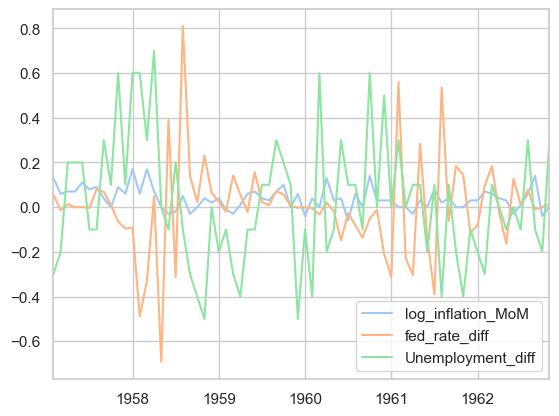

In [25]:
data_diff[["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]].iloc[30:100].plot()

<Axes: >

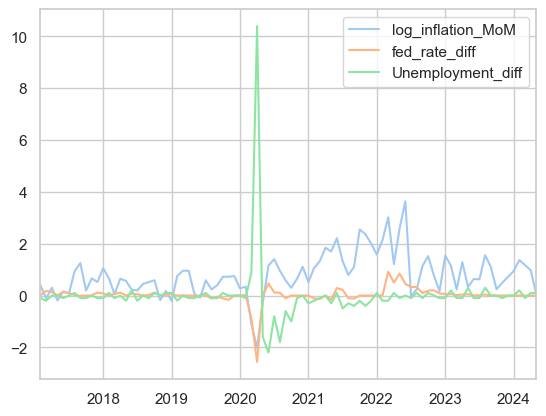

In [26]:
data_diff[["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]].iloc[750:].plot()

### Undifferenced time series

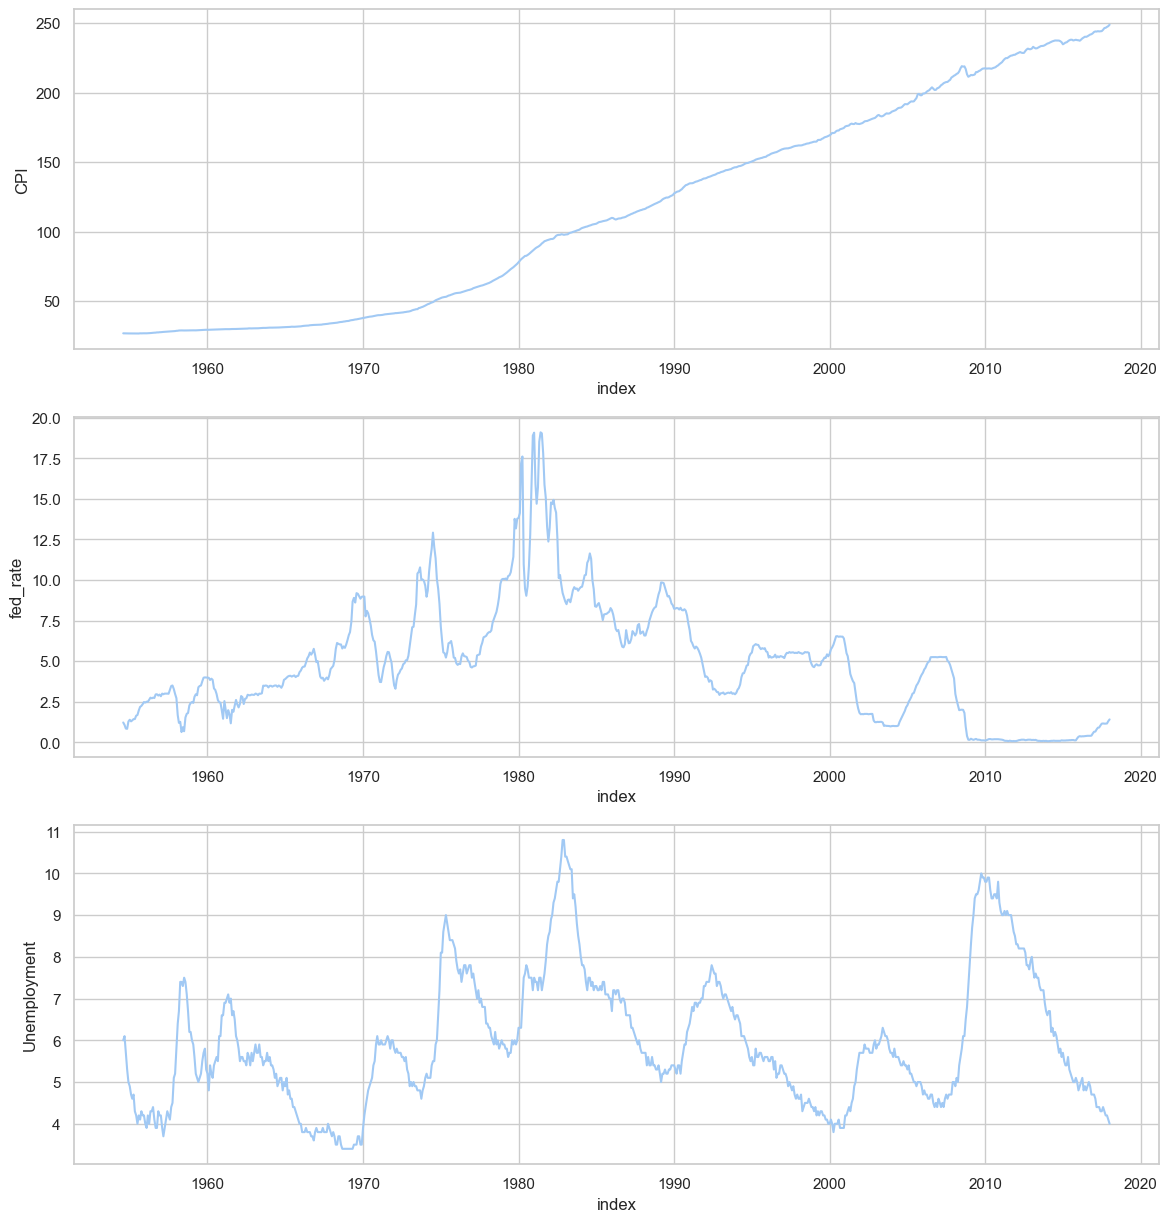

In [27]:
# Plot undifferenced data
sns.set_theme(style="whitegrid", palette="pastel")
fig, axs = plt.subplots(3,1, figsize=(14,15))
for i, series in enumerate(["CPI", "fed_rate", "Unemployment"]):
    g = sns.lineplot(
        data=data_diff.loc[:"2018-01-01",["CPI", "fed_rate", "Unemployment"]].reset_index(),
        x="index", y=series, ax=axs[i],
    )

### Better plots of transformed time series.

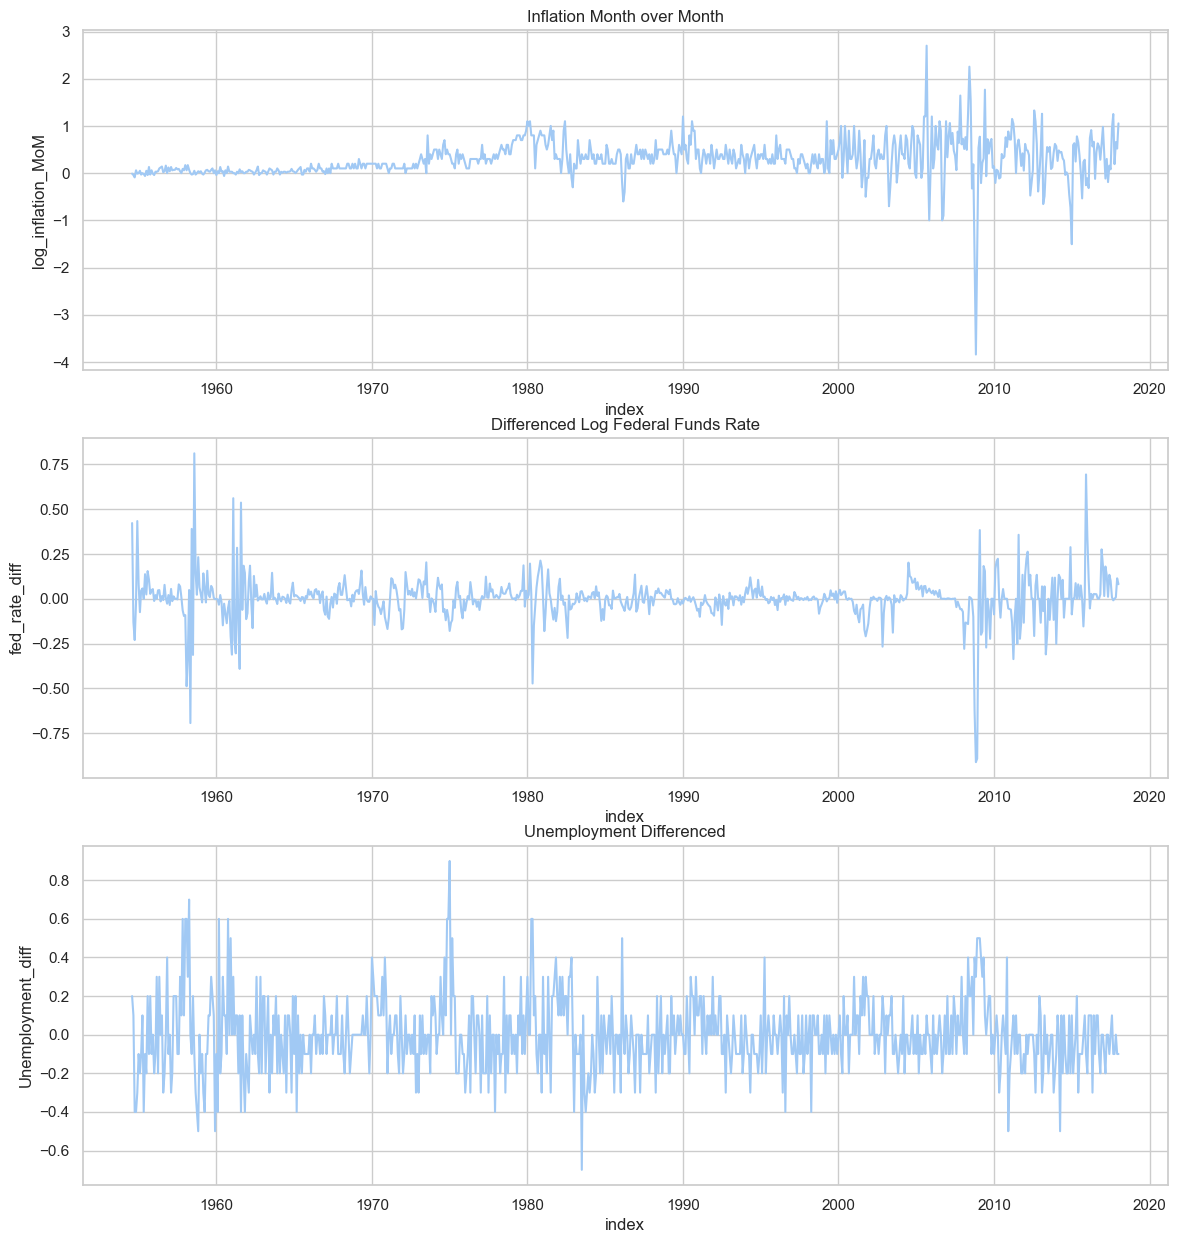

In [28]:
sns.set_theme(style="whitegrid", palette="pastel")
fig, axs = plt.subplots(3,1, figsize=(14,15))

series_names = {
    "log_inflation_MoM": "Inflation Month over Month",
    "fed_rate_diff": "Differenced Log Federal Funds Rate",
    "Unemployment_diff": "Unemployment Differenced",
}

for i, series in enumerate(["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]):
    axs[i].set_title(series_names[series])
    g = sns.lineplot(
        data=data_diff.loc[:"2018-01-01", ["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]].reset_index(),
        x="index", y=series, ax=axs[i],
    )

# Clearly the variance of the inflation data variance is growing over time and hence not stationary.

### Season plots

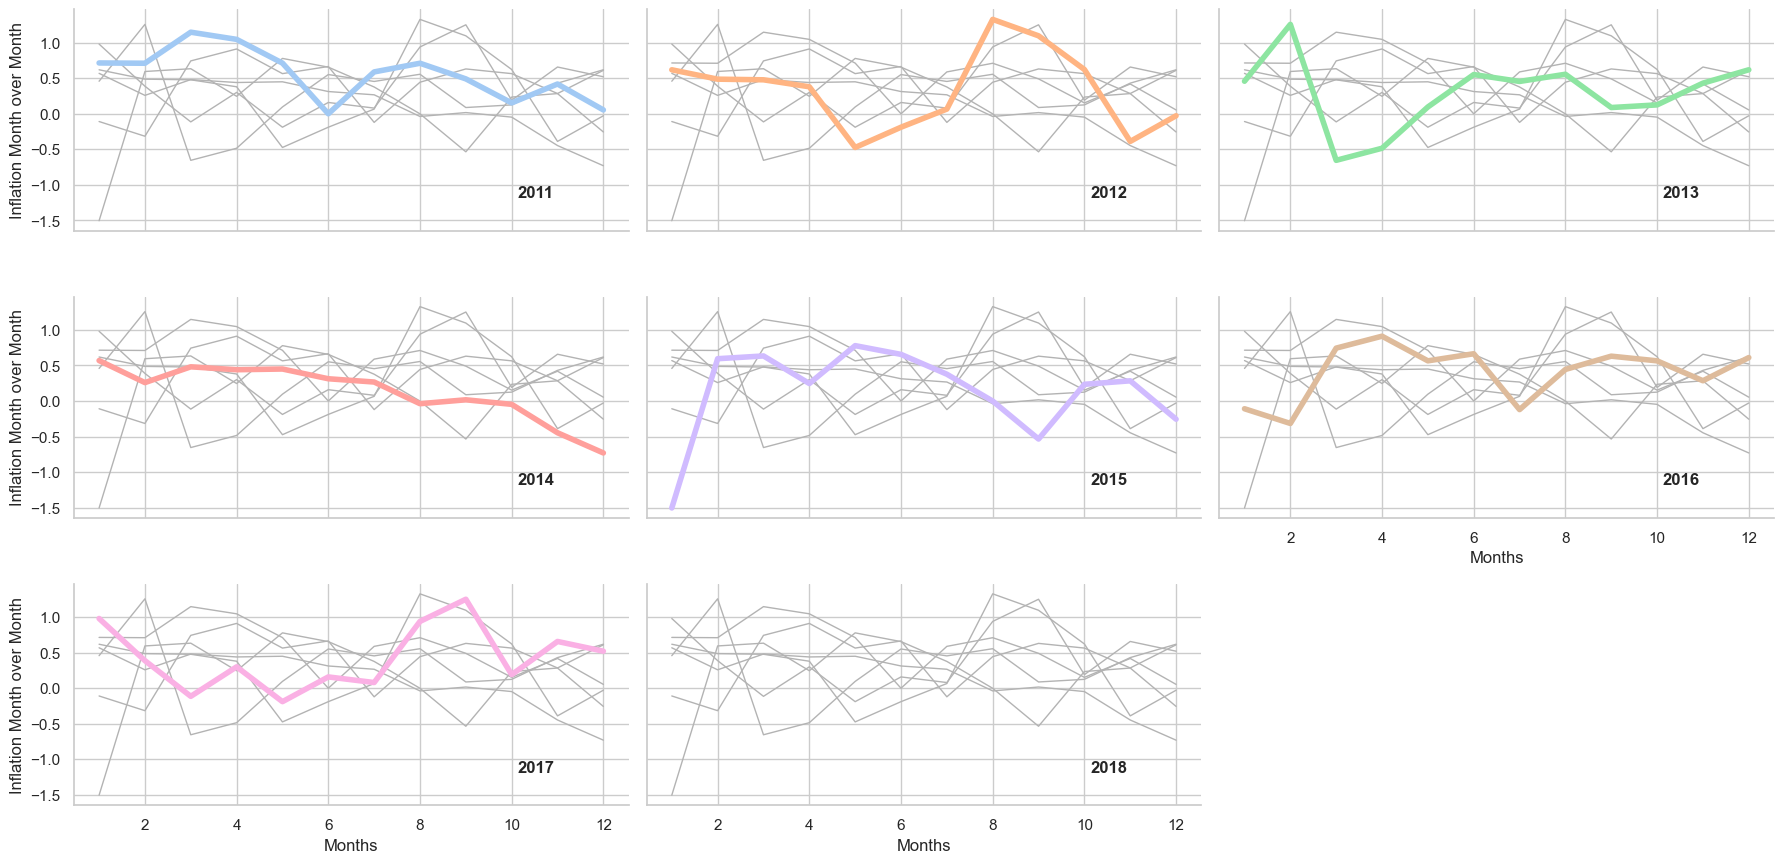

In [29]:
def monthly_facet_plot(data, var):
    data = data.copy()
    data.loc[:, "month"] = data.index.month
    data.loc[:, "year"] = data.index.year
    sns.set_theme(style="whitegrid", palette="pastel")
    
    g = sns.relplot(
        data=data,
        x="month", y=var, col="year", hue="year",
        kind="line", palette="pastel", linewidth=4, zorder=5,
        col_wrap=3, height=3, aspect=2, legend=False,
    )
    
    for year, ax in g.axes_dict.items():
        ax.set_title("")
        ax.text(.8, .15, year, transform=ax.transAxes, fontweight="bold")
    
        sns.lineplot(
            data=data, x="month", y=var, units="year",
            estimator=None, color=".7", linewidth=1, ax=ax,
        )
    g.set_axis_labels("Months", series_names[var])

data_window = data_diff["2011-01-01":"2018-01-01"]
monthly_facet_plot(data_window, "log_inflation_MoM")

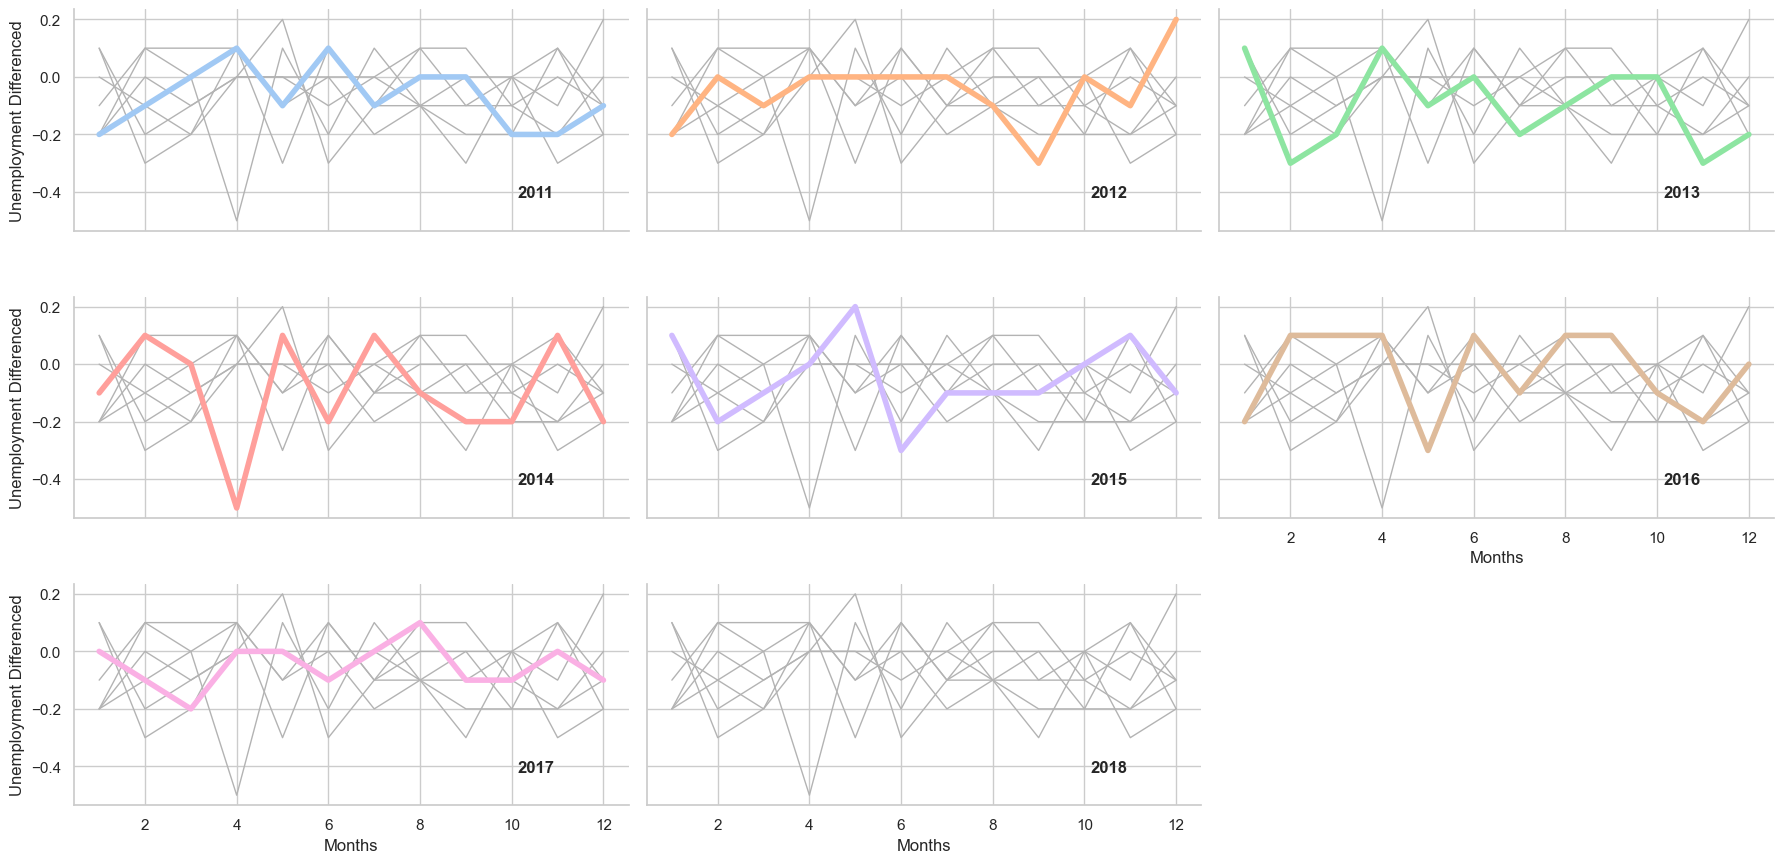

In [30]:
data_window = data_diff["2011-01-01":"2018-01-01"]
monthly_facet_plot(data_window, "Unemployment_diff")

In [31]:
# Create train and validation data cutoff dates
cutoff = int(data_diff.shape[0]*0.80)
print(cutoff)
validation_cutoff = int(cutoff*0.8)
print(validation_cutoff)

cutoff_date = str(data_diff.iloc[cutoff-1].name)
print("train+validation cutoff",cutoff_date)

validation_cutoff_date = str(data_diff.iloc[validation_cutoff-1].name)
print("validation cutoff", validation_cutoff_date)

670
536
train+validation cutoff 2010-05-01 00:00:00
validation cutoff 1999-03-01 00:00:00


## Time series stationary assesment

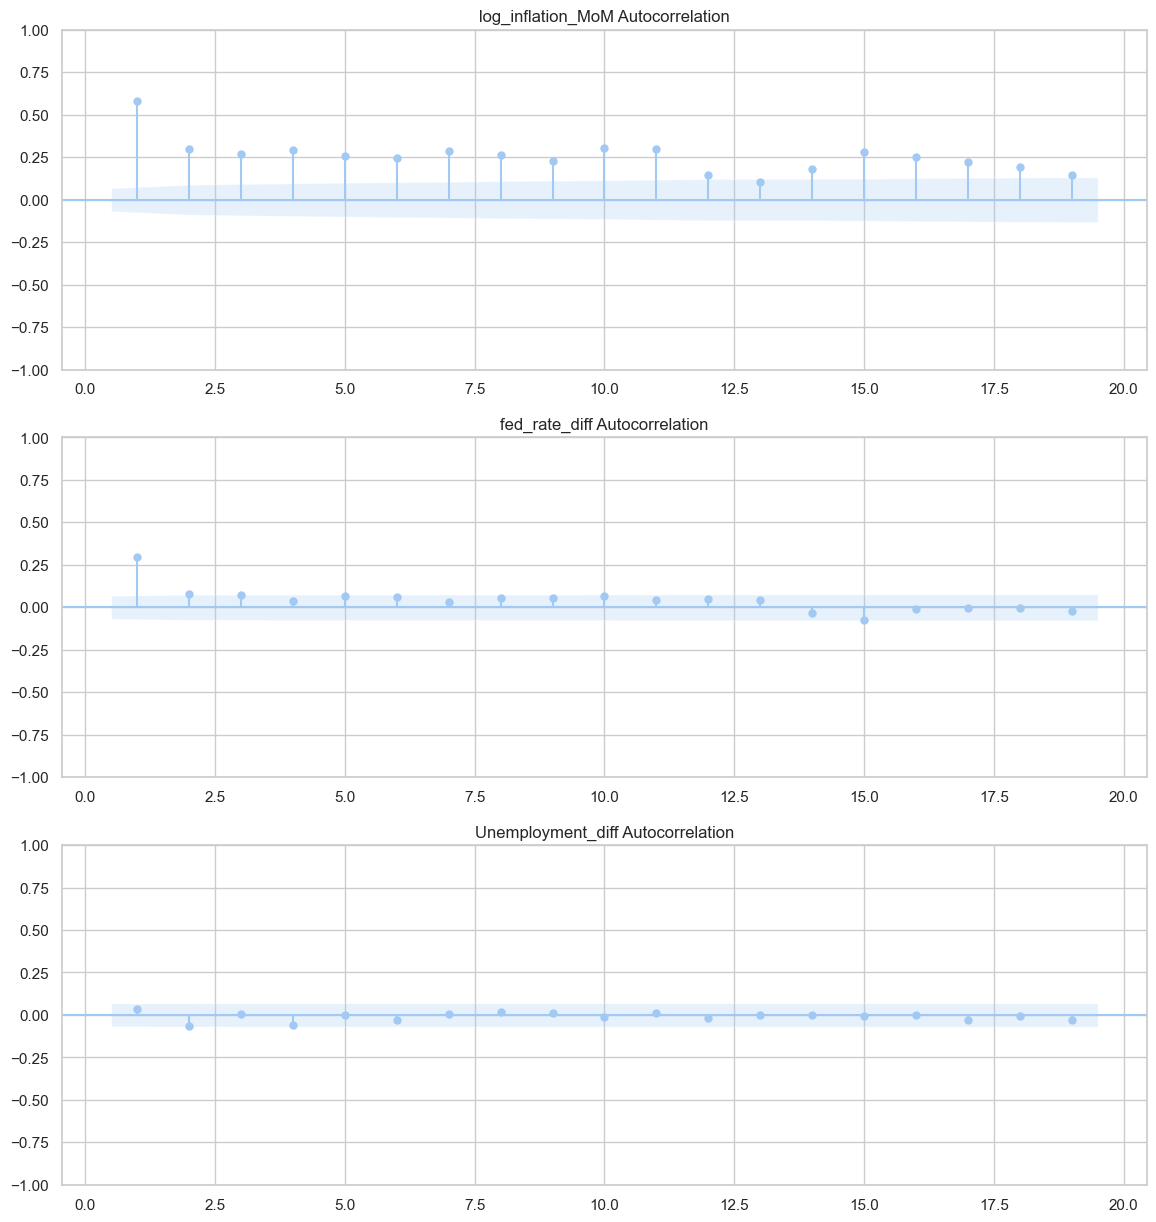

In [32]:
# ACF plots
fig, axs = plt.subplots(3,1, figsize=(14,15))
for i, series in enumerate(series_names.keys()):
    g = plot_acf(data_diff[series], ax=axs[i], lags=np.arange(1, 20))
    axs[i].set_title(f"{series} Autocorrelation")

### ADF tests with statsmodels fixing $\alpha=0.05$
### $H_0: \text{unit root}$ $H_A: \text{stationary}$

In [33]:
from statsmodels.tsa.stattools import adfuller
alpha = 0.05
for var in series_names.keys():
    p_value = adfuller(data_diff.loc[:cutoff_date, var], regression="n")[1]
    status = "Failed to reject H0. Unit root present." if p_value > alpha else "Reject H0. Data are stationary."
    print(f"ADF test p-value for {var}:", p_value, status)


ADF test p-value for log_inflation_MoM: 0.122023530036447 Failed to reject H0. Unit root present.
ADF test p-value for fed_rate_diff: 5.789450592980319e-09 Reject H0. Data are stationary.
ADF test p-value for Unemployment_diff: 5.5475106401127865e-12 Reject H0. Data are stationary.


In [35]:
# Since log inflation is not stationary, we will try a boxcox transform:
from scipy.stats import boxcox
transformed = boxcox(data["CPI"].dropna())


lambda_ = transformed[1]
transformed = pd.DataFrame(transformed[0], columns = ["CPI"], index = data["CPI"].dropna().index).diff().dropna()

p_value = adfuller(transformed.loc[:cutoff_date, :].dropna(), regression="c")[1]
status = "Failed to reject H0. Unit root present." if p_value > alpha else "Reject H0. Data are stationary."
print(p_value, status)

0.005791727187566754 Reject H0. Data are stationary.


In [37]:
# switch the log transformed inflation to the box-cox transform
def box_cox_transform_cpi(data):
    transformed = boxcox(data["CPI"].dropna())
    lambda_ = transformed[1]
    data.loc[~data['CPI'].isna(),'CPI'] = transformed[0]
    return data, lambda_
    
test_data = get_data(fred_data)
box_cox_transform_cpi(test_data)
test_data.loc[:,'CPI'].tail()

2024-01-01    10.251179
2024-02-01    10.264009
2024-03-01    10.274995
2024-04-01    10.284095
2024-05-01    10.284263
Freq: MS, Name: CPI, dtype: float64

Text(0.5, 1.0, 'Box-Cox transformed inflation Autocorrelation')

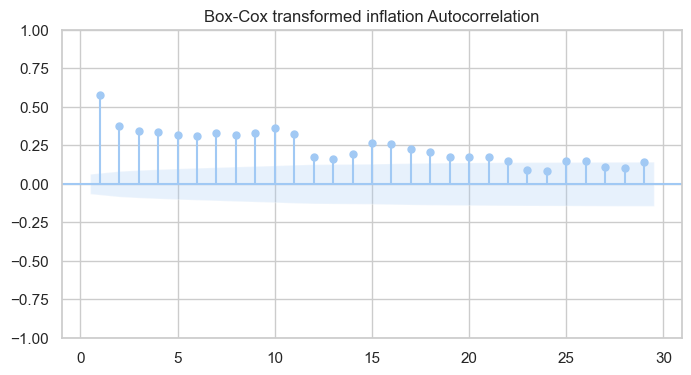

In [38]:
fig, axs = plt.subplots(1,1, figsize=(8,4))

g = plot_acf(test_data.loc[:,'CPI'].diff().dropna(), ax=axs, lags=np.arange(1, 30))
axs.set_title(f"Box-Cox transformed inflation Autocorrelation")

Text(0.5, 1.0, 'Differenced')

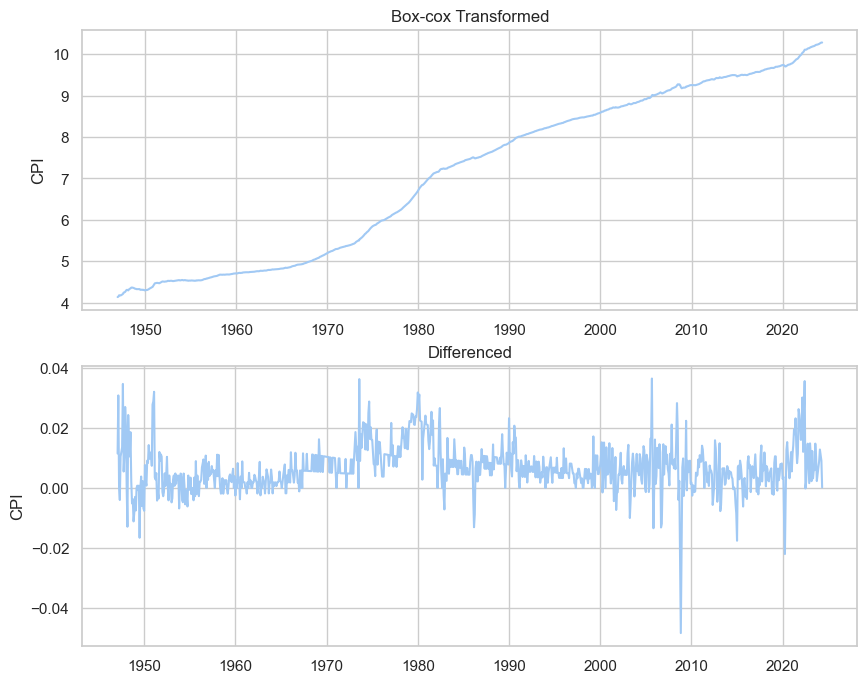

In [39]:
sns.set_theme(style="whitegrid", palette="pastel")
fig, ax = plt.subplots(2,1, figsize=(10,8))

ax[0].set_title("Box-cox Transformed")
g = sns.lineplot(
    data=test_data.loc[:,'CPI'], ax=ax[0]
)

g = sns.lineplot(
    data=test_data.loc[:,'CPI'].diff(), ax=ax[1]
)
ax[1].set_title("Differenced")

In [40]:
# Will difference CPI one more time since there appears to be a part where the mean shifts between around 1970  to about 1985

### Update config

In [41]:
%%writefile configs/time_series_config.yaml
FRED:
    CPIAUCSL:
        name: CPI
        log: false
        diff: true
        n_diffs: 2
        diff_name: log_inflation_MoM
    FEDFUNDS:
        name: fed_rate
        log: true
        diff: true
        n_diffs: 1
    UNRATE:
        name: Unemployment
        log: false
        diff: true
        n_diffs: 1

Overwriting configs/time_series_config.yaml


## Prepare data so it can be passed into PyTorch

In [42]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler() if scaling_mode == "min-max" else StandardScaler()


class MonetaryPolicyDataSet(torch.utils.data.Dataset):
    def __init__(self, mode:["train", "test", "validation", "full"]='train', train_end_date=None, 
                 validation_end_date=None, seq_length=3, transform = True):
        """ 
        Parameters
        ----------
        mode: str
            'train', 'test', 'validation'
        """
        self.data_mode = mode

        self.seq_length = seq_length

        # Get data configs.
        # Includes settings such as differencing the series or taking logs
        configs = get_data_config(config_path / "time_series_config.yaml")
        self.data_dict = configs["FRED"]
        
        
        data = get_data(self.data_dict)
        data, lambda_ = box_cox_transform_cpi(data)
        self.data = difference_data(data, self.data_dict)[["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]]

        if self.data_mode != "full":
            self.split_data(train_end_date, validation_end_date)
        
        # Convert to pytorch tensor
        if transform:
            self.data = scaler.transform(self.data)
            self.data = torch.tensor(self.data)
        else:
            self.data = torch.tensor(self.data.values)
        
        
    def __getitem__(self, t):
        return self.data[t: t + self.seq_length], self.data[t + self.seq_length]
    
    
    def __len__(self):
        return len(self.data) - self.seq_length
    

    def split_data(self, train_end_date, validation_end_date):
        if self.data_mode == "train":
            self.data = self.data.loc[:train_end_date]
            scaler.fit(self.data)
            
        elif self.data_mode == "validation":
            # Create  validation set after the train_end_date
            self.data = self.data.loc[pd.to_datetime(train_end_date) + pd.DateOffset(months=1) : validation_end_date]
        
        else:
            # Create test set after the validation_end_date
            assert validation_end_date is not None, "In testing mode, please add validation_end_date"
            self.data = self.data.loc[pd.to_datetime(validation_end_date) + pd.DateOffset(months=1):]

    
    def get_lambda(self):
        return lambda_
        

In [43]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def get_data_loaders(train_cutoff, validation_cutoff, seq_length, transform = True):
    # note: validation_cutoff_date is where the train set ends 
    train_dataset = MonetaryPolicyDataSet(
            mode="train", train_end_date=validation_cutoff,
            seq_length = seq_length, transform=transform
        )
    
    validation_dataset = MonetaryPolicyDataSet(
            mode="validation", train_end_date=validation_cutoff,
            validation_end_date= train_cutoff,
            seq_length = seq_length, transform=transform
        )
    
    test_dataset = MonetaryPolicyDataSet(
            mode='test', train_end_date=train_cutoff, 
            validation_end_date= train_cutoff,
            seq_length = seq_length, transform=transform
        )

    full_data = MonetaryPolicyDataSet(
            mode='full',
            seq_length = seq_length, 
            transform=transform
        )

    lambda_ = train_dataset.get_lambda()
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    full_dataloader = DataLoader(full_data, batch_size=batch_size)
    
    return train_dataloader, validation_dataloader, test_dataloader, full_dataloader, lambda_ 

train_dataloader, validation_dataloader, test_dataloader, full_dataloader, lambda_ = get_data_loaders(
        train_cutoff=cutoff_date, 
        validation_cutoff=validation_cutoff_date,
        seq_length=seq_length, 
        transform=True,
    )

# look at some train data
batch_id, (x, y) = next(enumerate(train_dataloader))
print(x, y)
print(x.size())

tensor([[[ 0.9176,  4.1256,  1.0222],
         [-0.3979, -1.3258,  0.5186],
         [-0.6636, -2.3013, -1.9993]],

        [[-0.3979, -1.3258,  0.5186],
         [-0.6636, -2.3013, -1.9993],
         [ 1.9780, -0.2676, -1.9993]],

        [[-0.6636, -2.3013, -1.9993],
         [ 1.9780, -0.2676, -1.9993],
         [-0.9269,  4.2359, -1.4957]],

        [[ 1.9780, -0.2676, -1.9993],
         [-0.9269,  4.2359, -1.4957],
         [ 0.1294,  0.7795, -0.4886]]], dtype=torch.float64) tensor([[ 1.9780, -0.2676, -1.9993],
        [-0.9269,  4.2359, -1.4957],
        [ 0.1294,  0.7795, -0.4886],
        [ 0.6569, -0.7687, -0.9922]], dtype=torch.float64)
torch.Size([4, 3, 3])


In [44]:
# Look at test data
batch_id, (x, y) = next(enumerate(test_dataloader))
print(x)

tensor([[[ 0.0502, -1.0713, -0.9922],
         [ 1.1904, -0.0330,  0.0150],
         [-0.2148,  0.4998,  0.5186]],

        [[ 1.1904, -0.0330,  0.0150],
         [-0.2148,  0.4998,  0.5186],
         [ 0.0779, -0.0330,  0.0150]],

        [[-0.2148,  0.4998,  0.5186],
         [ 0.0779, -0.0330,  0.0150],
         [ 0.9704, -0.0330, -0.4886]],

        [[ 0.0779, -0.0330,  0.0150],
         [ 0.9704, -0.0330, -0.4886],
         [-0.4955, -0.0330,  2.0294]]], dtype=torch.float64)


## Baseline Vector Auto Regression

In [45]:
var_train =  pd.DataFrame(train_dataloader.dataset.data, columns=["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]) 

var_test = pd.DataFrame(validation_dataloader.dataset.data, columns=["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"])
print(var_train.tail())
print(var_test.head())

     log_inflation_MoM  fed_rate_diff  Unemployment_diff
531          -0.608098      -0.510870          -0.488560
532           0.298241      -0.343875           0.015033
533          -0.003866      -0.138830          -0.488560
534          -0.905719       0.239900           0.518625
535           0.298244       0.069994          -0.992152
   log_inflation_MoM  fed_rate_diff  Unemployment_diff
0           2.995388      -0.177447           0.518625
1          -3.002206      -0.032980          -0.488560
2          -0.301520       0.008513           0.518625
3           2.086356       0.432038           0.015033
4          -0.900961       0.123755          -0.488560


In [46]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
model = VAR(var_train)

In [48]:
# Determine number of lags for the VAR
order = model.select_order(15)
print(order.summary())
print(order.selected_orders)
order_selection = order.selected_orders['aic']
# VAR of order 2 is selected for BIC criterion while order 10 is selected for AIC

fit = model.fit(maxlags=order_selection, ic="bic")
fit.summary()

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0      -0.1458     -0.1213      0.8643     -0.1362
1      -0.4290     -0.3310      0.6511     -0.3906
2      -0.5243    -0.3527*      0.5920     -0.4571
3      -0.5614     -0.3163      0.5704     -0.4654
4      -0.6285     -0.3100      0.5334    -0.5038*
5      -0.6527     -0.2606      0.5207     -0.4991
6      -0.6607     -0.1951      0.5165     -0.4783
7      -0.6657     -0.1266      0.5140     -0.4546
8     -0.6848*    -0.07213     0.5043*     -0.4448
9      -0.6608     0.02533      0.5166     -0.3921
10     -0.6734     0.08629      0.5102     -0.3758
11     -0.6757      0.1575      0.5091     -0.3493
12     -0.6697      0.2370      0.5122     -0.3146
13     -0.6652      0.3150      0.5146     -0.2813
14     -0.6714      0.3823      0.5116     -0.2586
15     -0.6604      0.4668      0.5173     -0.2189
-------------------------------

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 14, Jun, 2024
Time:                     07:42:19
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                  -0.307840
Nobs:                     534.000    HQIC:                 -0.410305
Log likelihood:          -2125.00    FPE:                   0.621161
AIC:                    -0.476170    Det(Omega_mle):        0.597360
--------------------------------------------------------------------
Results for equation log_inflation_MoM
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       -0.001303         0.038297           -0.034           0.973
L1.log_inflation_MoM        -0.526180         0.042793          -12.296           0.000
L1.fed_rate_diff    

In [49]:
# Generate forecasts
forecasts = fit.forecast(var_train.values[-order_selection:], var_test.shape[0])
assert len(forecasts) == var_test.shape[0]
forecasts[:5]

array([[ 0.04878851,  0.22461484,  0.02378122],
       [-0.01971427,  0.12321264, -0.25179882],
       [ 0.03015554,  0.0543605 , -0.04336061],
       [ 0.01135438,  0.04776277, -0.07883687],
       [-0.00157427,  0.02044005, -0.0263976 ]])

In [50]:
print(len(validation_dataloader.dataset.data))
print(var_test.shape[0])

134
134


In [51]:
# Calculate error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
forecasts_t = torch.tensor(forecasts)
mse = nn.MSELoss()
print("MSE",mse(forecasts_t, validation_dataloader.dataset.data))
print("MAE",mean_absolute_error(forecasts_t, validation_dataloader.dataset.data))

MSE tensor(2.2392, dtype=torch.float64)
MAE 0.9262037187725988


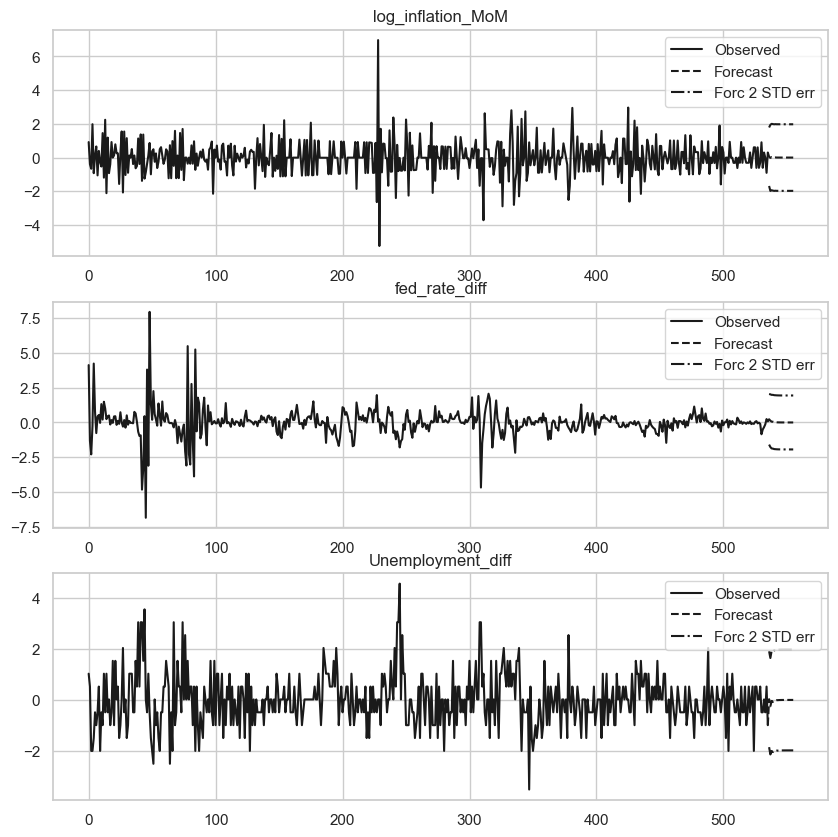

In [52]:
h = fit.plot_forecast(20)

## Build and test RNN

In [53]:
import torch.functional as F
class RNNModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        
        self.recurrent_layer = torch.nn.RNN(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = 1,
            batch_first = True,
            bidirectional = False
        )
        
        self.fc1 = torch.nn.Linear(hidden_size, 3, bias=True)

        self.latest_X = None
        
    def forward(self, x):
        x, hidden = self.recurrent_layer(x)
        x = self.fc1(x[:,-1, :])
        
        return x  

    def set_latest_X(self, X):
        self.latest_X = X

## Test forward

In [54]:
scaled_data = scaler.transform(data_diff[["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]])
scaled_data_df = pd.DataFrame(scaled_data, columns = ["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"], index=data_diff.index)
scaled_data_df = scaled_data_df[scaled_data_df != "2020-04-01"]
scaled_data_df.head()

,log_inflation_MoM,fed_rate_diff,Unemployment_diff
1954-08-01,-1.919049,4.125581,1.022217
1954-09-01,-7.668626,-1.325819,0.518625
1954-10-01,-17.251255,-2.301275,-1.999336
1954-11-01,11.496631,-0.267623,-1.999336
1954-12-01,-1.919049,4.235905,-1.495744


In [55]:
# Test forward pass
model = RNNModel(3, 20)
torch.manual_seed(1)
test_input = x.float()
print("Input:")
print(test_input.float())
print(test_input.shape)
with torch.no_grad():
    print("Output: ")
    out = model(test_input)
    print(out)
    print("true values:", y.float())

Input:
tensor([[[ 0.0502, -1.0713, -0.9922],
         [ 1.1904, -0.0330,  0.0150],
         [-0.2148,  0.4998,  0.5186]],

        [[ 1.1904, -0.0330,  0.0150],
         [-0.2148,  0.4998,  0.5186],
         [ 0.0779, -0.0330,  0.0150]],

        [[-0.2148,  0.4998,  0.5186],
         [ 0.0779, -0.0330,  0.0150],
         [ 0.9704, -0.0330, -0.4886]],

        [[ 0.0779, -0.0330,  0.0150],
         [ 0.9704, -0.0330, -0.4886],
         [-0.4955, -0.0330,  2.0294]]])
torch.Size([4, 3, 3])
Output: 
tensor([[-0.0434, -0.0838,  0.0420],
        [-0.1982, -0.0940,  0.0744],
        [-0.1882, -0.1323,  0.1035],
        [-0.1158,  0.0712,  0.0422]])
true values: tensor([[ 0.0779, -0.0330,  0.0150],
        [ 0.9704, -0.0330, -0.4886],
        [-0.4955, -0.0330,  2.0294],
        [ 0.7711, -0.5658, -2.5029]])


In [56]:
mse = nn.MSELoss()
mse(model(test_input), y)

tensor(1.0989, dtype=torch.float64, grad_fn=<MseLossBackward0>)

## Train RNN

In [60]:
from torch import optim
import torch.nn as nn

class RNN:
    def __init__(self, rnn, model_name, n_epoch:int, 
                 train_loader, validation_loader=None, 
                 learning_rate:float=0.0001, gradient_clipping=None,
                 device = None, train_data_end_date = None,
                ):
        """ Trainer for the rnn.
        
        Parameters
        ----------
        rnn : torch.nn.Module
            PyTorch model to be trained
        model_name : str
            name of the model that will be saved models folder
        n_epoch : int
            number of epochs for training
        train_loader : DataLoader
        validation_loader : DataLoader
        learning_rate : float
        gradient_clipping: bool
            Clip large gradients
        device: str
            Device used for training
        train_data_end_date: str
            The date where the train data ends
        """
        self.n_epoch, self.lr, self.graident_clip = n_epoch, learning_rate, gradient_clipping

        self.train_loader, self.validation_loader = train_loader, validation_loader
        
        self.net = rnn
        self.model_name = model_name
        
        self.optimizer = optim.Adam(
                lr=self.lr, 
                params=self.net.parameters()
            ) 
        
        # Mean squared error loss
        self.loss = nn.MSELoss()

        self.best_validation_loss = 1000000 # arbritrary large number just to initialize
        self.best_model = None
        self.device = device
        
        # Keep track of date when the train set ends
        self.train_data_end_date = train_data_end_date

        
    def train(self):
        with mlflow.start_run() as run:
            self.run = run
            self.log_params()
            
            self.train_error = []
            self.val_error = []
            for epoch in range(1, self.n_epoch + 1):
                self.train_loop(epoch)
                if self.validation_loader:
                    self.validation(epoch)
            self.log_loss()
            
            if self.validation_loader:
                self.log_model(self.best_validation_loss)
                mlflow.log_metric("Best-validation-loss", self.best_validation_loss)
            else:
                torch.save(self.net, model_folder / f"{self.model_name}.pt")
        
        
    def train_loop(self, epoch):
        self.net.train()
        losses = []
        for idx, (x, y) in enumerate(self.train_loader):
            
            x = x.to(self.device).float()
            y = y.to(self.device).float()

            # Calculate losses and optimize 
            self.optimizer.zero_grad()
            output = self.net(x)
            loss = self.loss(output, y)
            losses.append(loss.item())
            loss.backward()

            if self.graident_clip:
                nn.utils.clip_grad_norm_(self.net.parameters(), self.graident_clip)

            self.optimizer.step()

            # Print progress
            if idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, idx * len(x), len(self.train_loader.dataset),
                100. * idx / len(self.train_loader), loss.item()))
                
        avg_loss = np.mean(losses)
        self.train_error.append(avg_loss)
        print("Epoch {} average train loss: {:.6f}".format(epoch, avg_loss))
        self.net.set_latest_X(x)
    
    def validation(self, epoch):
        """
        Test model on validation data
        """
        losses = []
        for idx, (x, y) in enumerate(self.validation_loader):
            x = x.to(self.device).float()
            y = y.to(self.device).float()
            
            self.net.eval()
            with torch.no_grad():
                validation_output = self.net(x)#.reshape(-1,3)
                loss_val = self.loss(validation_output, y)
                losses.append(loss_val.item())
                
        avg_loss = np.mean(losses)

        # Track the best model and validation loss
        if avg_loss < self.best_validation_loss:
            self.best_validation_loss = avg_loss
            torch.save(self.net, model_folder / f"{self.model_name}.pt")
            
        self.val_error.append(avg_loss)
        print("Epoch {} average validation loss: {:.6f}".format(epoch, avg_loss))
    
    
    def log_params(self):
        """
        Logging model parameters with MLflow
        """
        mlflow.log_params(
            {
                "batch size": batch_size,
                "epochs": self.n_epoch,
                "sequence length": seq_length,
                "learning_rate": self.lr,
                "hidden size": self.net.hidden_size,
                "optimizer": self.optimizer,
                "gradient clipping": self.graident_clip,
                "Train data end": self.train_data_end_date,
                "Train data size": len(train_dataloader.dataset),
                "Validation data size": len(test_dataloader.dataset),
                "scaling": scaling_mode,
            }
        )
 

    def log_model_weights(self, epoch):
        """
        Logs the models parameters ever couple of epochs.
        """
        if epoch % 10 == 0:
            with torch.no_grad():
                for i, param in enumerate(self.net.parameters()):
                    p = param.cpu().numpy()
                    df = pd.DataFrame(p)
                    df.to_csv(f"./params/params_{i}.csv")
                mlflow.log_artifacts("./params", f"./params/{epoch}")


    def log_model(self, loss):
        """
        Uses MLflow to log the best model in pytorch flavour
        """
        print("Saving best model with lowest validation mse loss = {}".format(loss))        
        best_model = torch.load(model_folder / f"{self.model_name}.pt")
        best_model.eval()
        mlflow.pytorch.log_model(best_model, "best_model")
        mlflow.sklearn.log_model(scaler, "scaler")


    def log_loss(self):
        """
        Logging train and validation performance with MLflow
        """
        log_every = 10
        for epoch, val in enumerate(self.train_error):
            if epoch % log_every == 0:
                mlflow.log_metric(f"train mean loss", val, step=epoch)
        if self.validation_loader:
            for epoch, val in enumerate(self.val_error):
                if epoch % log_every == 0:
                    mlflow.log_metric(f"val-loss", val, step=epoch)

    
    def predict(self, x:torch.tensor):
        """
        Generate a prediction with the model. 
        Each output contains predictions for inflation, unemployment, and Fed rate.
        input:
            x: tensor size [n_samples, 3]
        returns:
            torch.tensor: size [n_samples, 3]
        """
        with torch.no_grad():
            return self.net(x.to(self.device).float())
            
            
    def load_model(self, path):
        """
        Load a pytorch model
        input:
            path: path to torch model
        """
        self.net = torch.load(path)

    def set_model(self, model):
        self.net = model

In [542]:
# Set the training experiment
mlflow.set_experiment('MonetaryPolicyRNN')
hidden_size = 16

# Initialize model
model = RNNModel(3, hidden_size).to(device)
rnn = RNN(model, "RNN", 120, train_dataloader, validation_dataloader, 
          learning_rate=0.0001, device=device, train_data_end_date=cutoff_date)
# Train
rnn.train()

Train Epoch: 1 [0/531 (0%)]	Loss: 0.568092
Train Epoch: 1 [400/531 (75%)]	Loss: 0.394311
Epoch 1 average train loss: 1.007544
Epoch 1 average validation loss: 2.136593
Train Epoch: 2 [0/531 (0%)]	Loss: 0.536512
Train Epoch: 2 [400/531 (75%)]	Loss: 0.390937
Epoch 2 average train loss: 0.981648
Epoch 2 average validation loss: 2.123140
Train Epoch: 3 [0/531 (0%)]	Loss: 0.514346
Train Epoch: 3 [400/531 (75%)]	Loss: 0.390264
Epoch 3 average train loss: 0.962798
Epoch 3 average validation loss: 2.112486
Train Epoch: 4 [0/531 (0%)]	Loss: 0.496919
Train Epoch: 4 [400/531 (75%)]	Loss: 0.390822
Epoch 4 average train loss: 0.948354
Epoch 4 average validation loss: 2.103978
Train Epoch: 5 [0/531 (0%)]	Loss: 0.482508
Train Epoch: 5 [400/531 (75%)]	Loss: 0.391877
Epoch 5 average train loss: 0.936792
Epoch 5 average validation loss: 2.097181
Train Epoch: 6 [0/531 (0%)]	Loss: 0.470156
Train Epoch: 6 [400/531 (75%)]	Loss: 0.393033
Epoch 6 average train loss: 0.927218
Epoch 6 average validation loss: 2

2024/06/12 14:52:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch 120 average validation loss: 2.317708
Saving best model with lowest validation mse loss = 2.078821823000908


2024/06/12 14:52:16 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
C:\Users\armym\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\armym\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setup

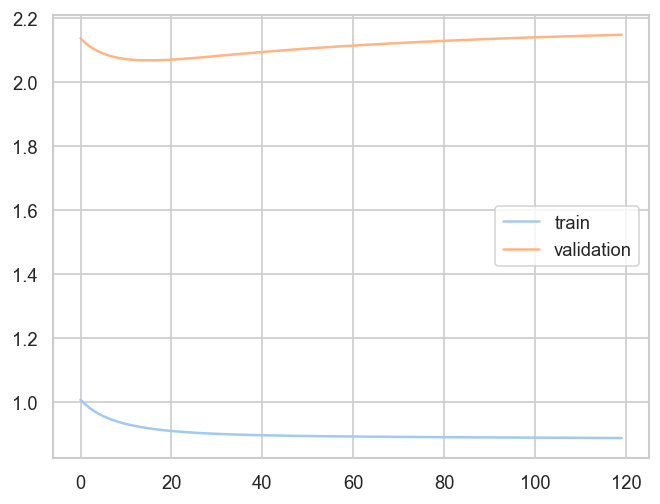

In [429]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=120)

ax.plot(np.arange(len(rnn.train_error)), rnn.train_error, label='train')
ax.plot(np.arange(len(rnn.val_error)), rnn.val_error, label='validation')
plt.legend()

## Look at some of the fitted values

In [545]:
rnn.load_model("./models/RNN.pt")

In [61]:
def get_predictions(model, loader, return_residuals = False):
    """ Produces model predictions from data in loader. Can
    optionally return model residuals as well.
    Parameters
    ----------
    model: torch.nn.Module
        pytorch model to use for producing predictions
    loader: torch.utils.data.DataLoader
        data loader that contains the data for 
    """
    predictions = []
    residuals = []
    for idx, (x, y) in enumerate(loader):
        pred = model.predict(x)
        predictions.append(pred)
        
        res = pred-y.to(device)
        residuals.append(res)
        
    predictions_concat = torch.concat(predictions, dim=0).cpu().numpy()
    residuals_concat = torch.concat(residuals, dim=0).cpu().numpy()
    if return_residuals:
        return predictions_concat, residuals_concat
    else:
        return predictions_concat

In [62]:

def plot_predictions(model, range_:list, loader, transform = False):
    predictions = get_predictions(model, loader)
    
    # If we are testing we need to start the index at the cutoff for when we concatinate predictions 
    # with the actual values
    
    predictions_df = pd.DataFrame(
        predictions, 
        columns = ["log_inflation_MoM_pred", "fed_rate_diff_pred", "Unemployment_diff_pred"], 
    )

    fig, axs = plt.subplots(3, dpi=120, figsize=(12, 10))
    all_data = pd.concat([pd.DataFrame(loader.dataset.data, columns=["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]), predictions_df], 
                         ignore_index=False, axis=1)

    if transform:
        all_data[["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]] = scaler.inverse_transform(
            all_data[["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]]
        )
        all_data[["log_inflation_MoM_pred", "fed_rate_diff_pred", "Unemployment_diff_pred"]] = scaler.inverse_transform(
            all_data[["log_inflation_MoM_pred", "fed_rate_diff_pred", "Unemployment_diff_pred"]]
        )
        (all_data[["log_inflation_MoM_pred", "log_inflation_MoM"]]).iloc[range_[0]:range_[1]].plot(ax=axs[0])
        (all_data[["fed_rate_diff_pred", "fed_rate_diff"]]).iloc[range_[0]:range_[1]].plot(ax=axs[1])
        (all_data[["Unemployment_diff_pred", "Unemployment_diff"]]).iloc[range_[0]:range_[1]].plot(ax=axs[2])
    else:
        (all_data[["log_inflation_MoM_pred", "log_inflation_MoM"]]).iloc[range_[0]:range_[1]].plot(ax=axs[0])
        (all_data[["fed_rate_diff_pred", "fed_rate_diff"]]).iloc[range_[0]:range_[1]].plot(ax=axs[1])
        (all_data[["Unemployment_diff_pred", "Unemployment_diff"]]).iloc[range_[0]:range_[1]].plot(ax=axs[2])

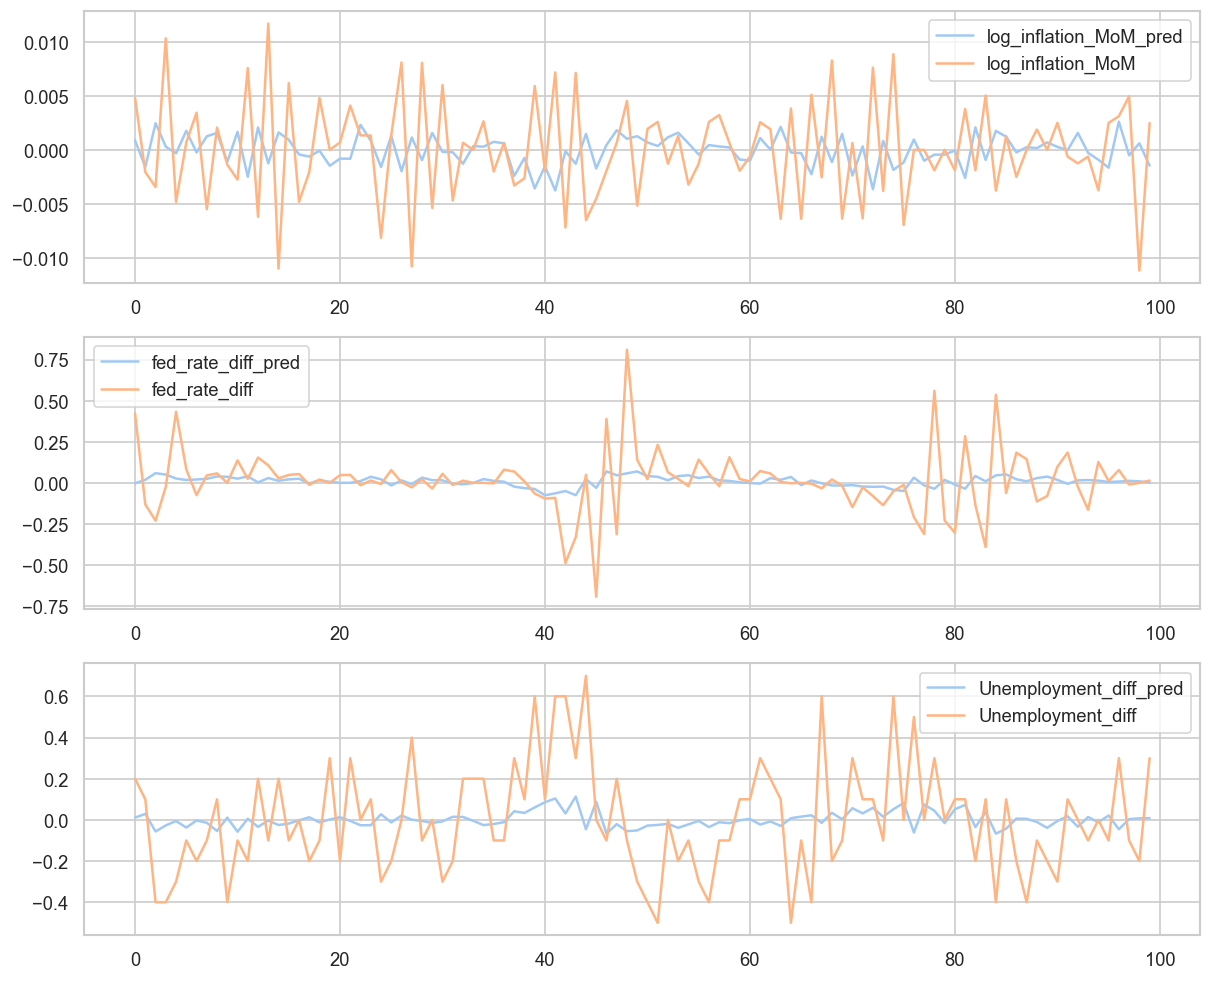

In [859]:
plot_predictions(rnn, [0, 100], train_dataloader, transform=True)

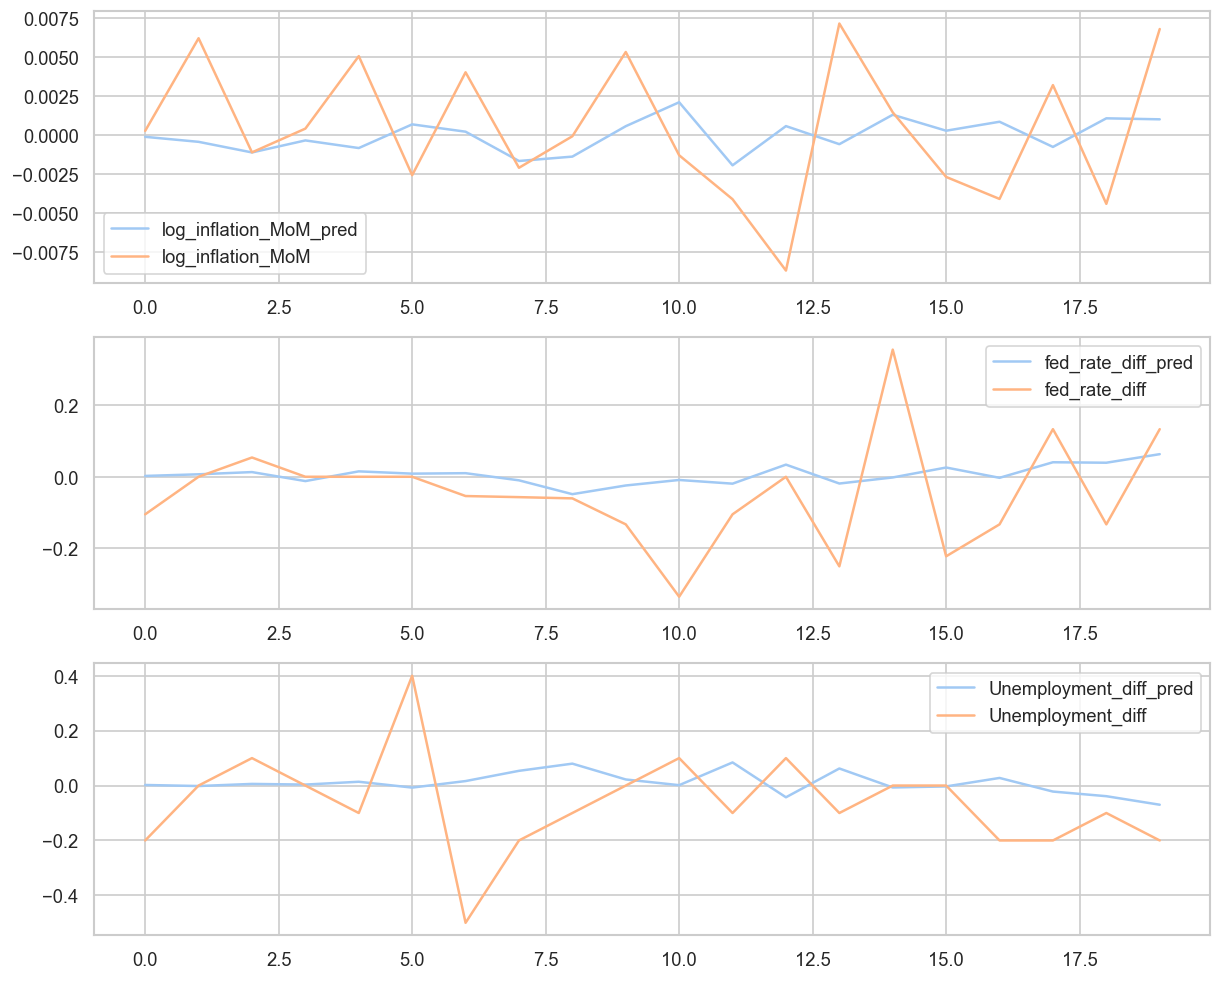

In [860]:
plot_predictions(rnn, [0, 20], test_dataloader, transform=True)

## Check that residuals are white noise

Text(0.5, 1.0, 'Unemployment_DIFF_pred Residuals')

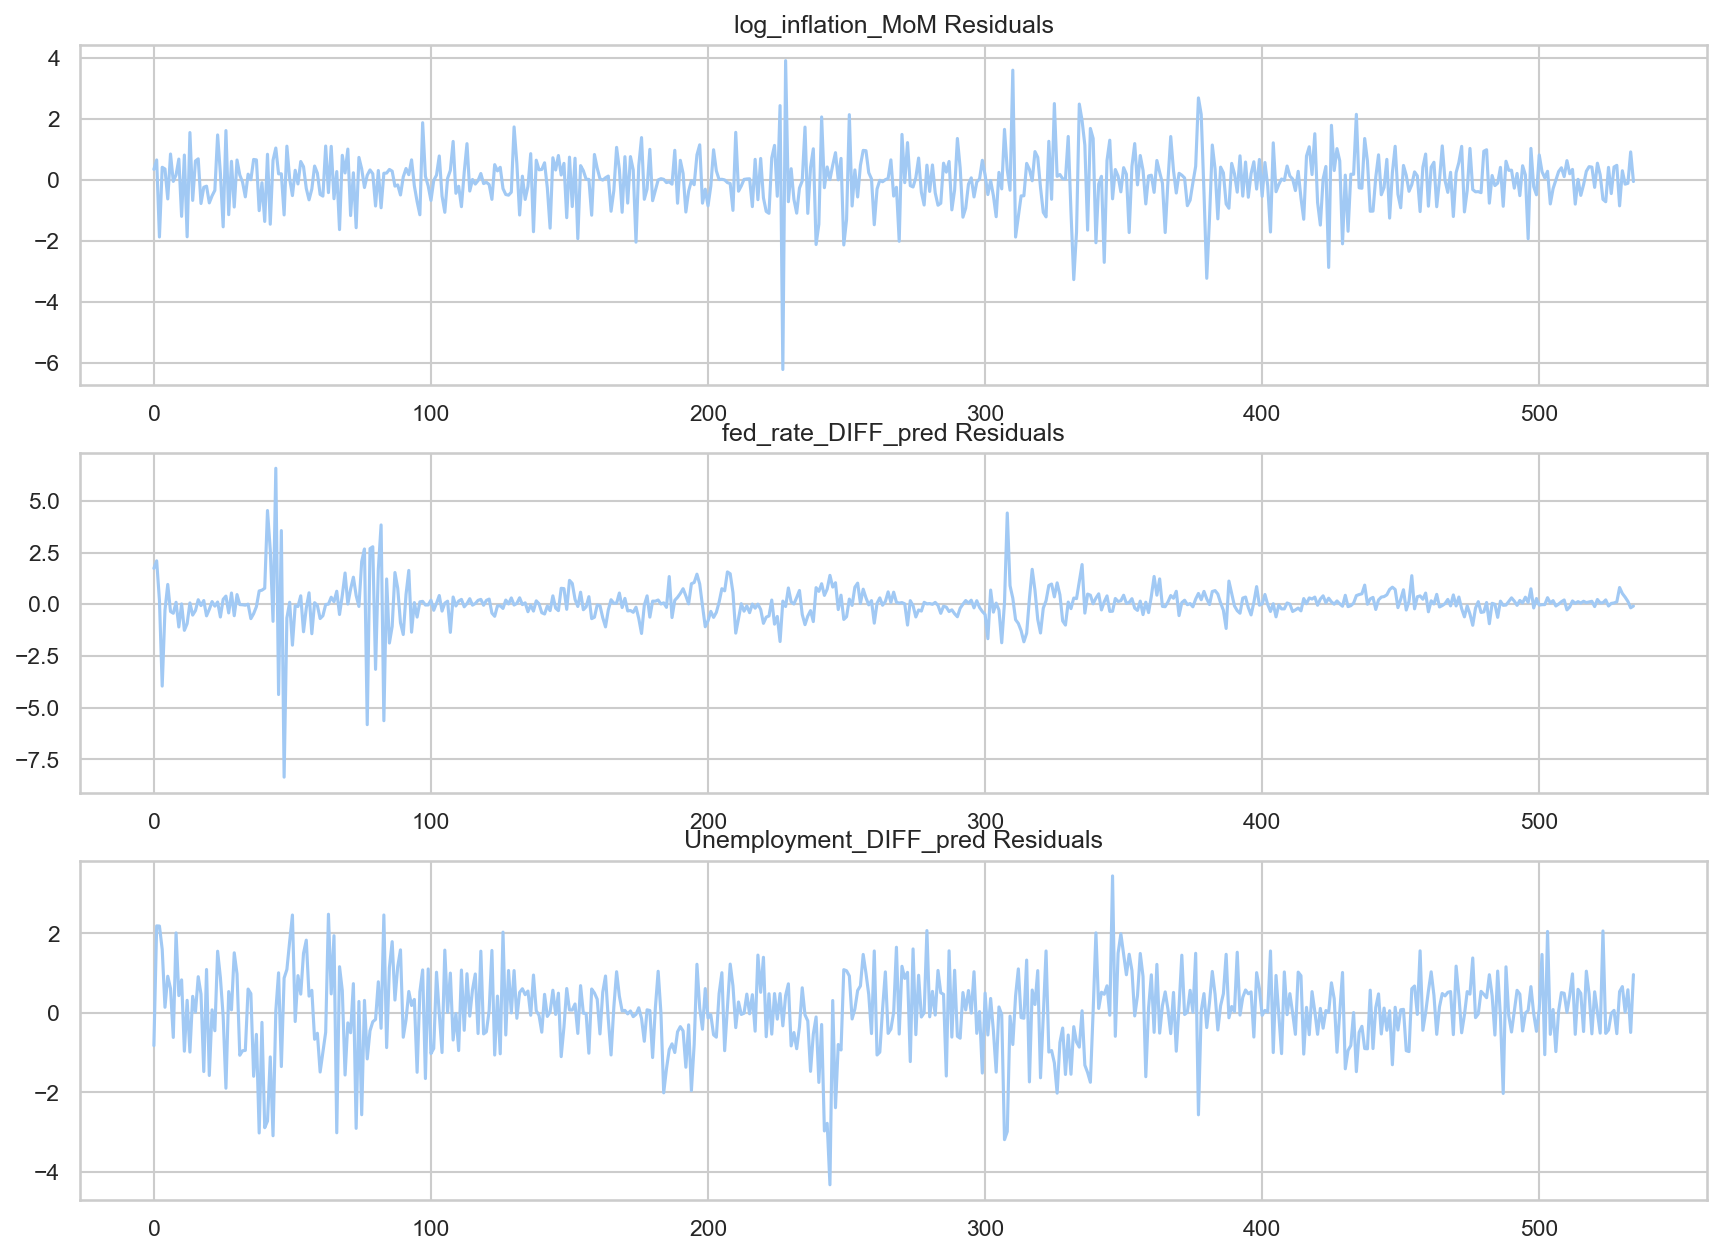

In [441]:
pred, res = get_predictions(rnn, train_dataloader,return_residuals=True)
residuals_df = pd.DataFrame(
        res, 
        columns = ["log_inflation_MoM_pred_res", "fed_rate_DIFF_pred_res", "Unemployment_DIFF_pred_res"]
    )

fig, axs = plt.subplots(3, dpi=150, figsize=(14, 10))

residuals_df["log_inflation_MoM_pred_res"].plot(ax=axs[0])
residuals_df["fed_rate_DIFF_pred_res"].plot(ax=axs[1])
residuals_df["Unemployment_DIFF_pred_res"].plot(ax=axs[2])
axs[0].set_title("log_inflation_MoM Residuals")
axs[1].set_title("fed_rate_DIFF_pred Residuals")
axs[2].set_title("Unemployment_DIFF_pred Residuals")

----

# LSTM With Pytorch

----

## Input gate, output gate, and forget gate
$\mathbf{I}_t = \sigma(\mathbf{X}_t\mathbf{W}_{xi} + \mathbf{H}_{t-1}\mathbf{W}_{hi} + \mathbf{b}_{i}) \\ $

$\mathbf{O}_t = \sigma(\mathbf{X}_t\mathbf{W}_{xo} + \mathbf{H}_{t-1}\mathbf{W}_{ho} + \mathbf{b}_{o}) \\ $,

$\mathbf{F}_t = \sigma(\mathbf{X}_t\mathbf{W}_{xf} + \mathbf{H}_{t-1}\mathbf{W}_{hf} + \mathbf{b}_{f})$

In [68]:
class Gate(nn.Module):
    def __init__(self, input_size, hidden_size, activation = "sigmoid"):
        super(Gate, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Params for input gate
        self.W_xi = nn.Parameter(
            torch.randn(input_size, hidden_size),
        )
        
        self.W_hi = nn.Parameter(
            torch.randn(hidden_size, hidden_size),
        )
         
        self.b_i = nn.Parameter(
            torch.zeros(hidden_size),     
        )
        
        
        self.activation = nn.Tanh() if activation == "tanh" else nn.Sigmoid()

        self.initialize_params()


    def initialize_params(self):
        a = np.sqrt(1/self.hidden_size)
        for param in self.parameters():
            param.data.uniform_(-a, a)
        
    
    def forward(self, X, old_state = None):
        if old_state is None:
            # Initiallize hidden state
            old_state = torch.zeros((X.shape[0], self.hidden_size),
                          device=X.device)   

        return self.activation(torch.matmul(X, self.W_xi) + 
                              torch.matmul(old_state, self.W_hi) + self.b_i) 

In [69]:
# Test the input gate forward pass
I = Gate(3, 5).to(device)
with torch.no_grad():
    print(x[0].shape)
    print(I(x[0].to(device).float()))

torch.Size([3, 3])
tensor([[0.5557, 0.3921, 0.7176, 0.7480, 0.4842],
        [0.4369, 0.5566, 0.6124, 0.6278, 0.6331],
        [0.3661, 0.5679, 0.5053, 0.4786, 0.6017]], device='cuda:0')


## Build the memory cell:
Input node:

$\mathbf{\tilde{C}}_t = \tanh{(\mathbf{X}_t\mathbf{W}_{xc} + \mathbf{H}_{t-1}\mathbf{W}_{hc} + \mathbf{b}_{c})}$

$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \mathbf{\tilde{C}}_t$

Update hidden state:

$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t)$


In [70]:
class MemoryCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MemoryCell, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.I = Gate(self.input_size, self.hidden_size)
        self.F = Gate(self.input_size, self.hidden_size)
        self.O = Gate(self.input_size, self.hidden_size)
        
        self.input_node = Gate(self.input_size, self.hidden_size, activation='tanh')
        
        self.tanh = nn.Tanh()

    
    def forward(self, X, state = None, internal_state = None):
        if state is None:
            state = torch.zeros((X.shape[1], self.hidden_size),
                          device=X.device)    
        if internal_state is None:
            internal_state = torch.zeros((X.shape[1], self.hidden_size),
                          device=X.device)  
            
        outputs = []
        for x in X:
            I = self.I(x, state)
            F = self.F(x, state)
            O = self.O(x, state)
            input_ = self.input_node(x, state)
            internal_state = F * internal_state + I * input_
            state = O * torch.tanh(internal_state)
            outputs.append(state)
            
        try:
            h = torch.stack(outputs, 0)
        except Exception as e:
            print(e)
            print("shape:", X.shape)
            print("outputs:", outputs)
        else:
            return h, (state, internal_state)

In [71]:
# Test forward
torch.manual_seed(1)
memory = MemoryCell(3, 5).to(device)
with torch.no_grad():
    o, _ = memory(x.to(device).float())
    print(o)

tensor([[[-0.0796, -0.0059,  0.0030,  0.1626, -0.0081],
         [-0.0778, -0.0451,  0.0361,  0.1081,  0.1765],
         [-0.0322,  0.0912, -0.1152,  0.0260,  0.0436]],

        [[-0.1147, -0.0359,  0.0433,  0.2138,  0.1625],
         [-0.0749,  0.0752, -0.1020,  0.0788,  0.1058],
         [-0.0660,  0.0821, -0.1427,  0.0760,  0.0679]],

        [[-0.1020,  0.0828, -0.0926,  0.1365,  0.0971],
         [-0.0936,  0.0830, -0.1397,  0.1037,  0.0903],
         [-0.1097,  0.0096, -0.0397,  0.1260,  0.1574]],

        [[-0.1151,  0.0899, -0.1312,  0.1352,  0.0844],
         [-0.1231,  0.0142, -0.0408,  0.1397,  0.1666],
         [-0.0725,  0.0977, -0.1830,  0.1450,  0.1097]]], device='cuda:0')


In [72]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size

        self.memory = MemoryCell(input_size, hidden_size)
        
        self.fc1 = nn.Linear(hidden_size, 3)

        self.latest_X = None
    
    def forward(self, X):
        x, (h, c) = self.memory(X)
        return self.fc1(x[:, -1, :])

    def set_latest_X(self, X):
        self.latest_X = X

In [73]:
# Test forward
#torch.manual_seed(1)
lstm = LSTM(3, 16)
with torch.no_grad():
    print(x)
    o = lstm(x.float())
    print(o)

tensor([[[ 0.0502, -1.0713, -0.9922],
         [ 1.1904, -0.0330,  0.0150],
         [-0.2148,  0.4998,  0.5186]],

        [[ 1.1904, -0.0330,  0.0150],
         [-0.2148,  0.4998,  0.5186],
         [ 0.0779, -0.0330,  0.0150]],

        [[-0.2148,  0.4998,  0.5186],
         [ 0.0779, -0.0330,  0.0150],
         [ 0.9704, -0.0330, -0.4886]],

        [[ 0.0779, -0.0330,  0.0150],
         [ 0.9704, -0.0330, -0.4886],
         [-0.4955, -0.0330,  2.0294]]], dtype=torch.float64)
tensor([[-0.1290,  0.2125, -0.2127],
        [-0.1385,  0.2363, -0.2223],
        [-0.1448,  0.2608, -0.2311],
        [-0.0462,  0.2591, -0.2479]])


### Train LSTM

In [ ]:
hidden_size = 12
seq_length = 3
train_dataloader, validation, test_dataloader, full_data_loader, lambda_ = get_data_loaders(cutoff_date, validation_cutoff_date, seq_length, transform=True)

lstm = LSTM(3, hidden_size).to(device)
lstm_model = RNN(lstm, "LSTM", 120, train_dataloader, validation_dataloader, 
                 learning_rate=0.0001, device=device, train_data_end_date=cutoff_date)

mlflow.set_experiment('LSTM_training')
# Train LSTM
lstm_model.train()

In [79]:
experiment_id = mlflow.get_experiment_by_name("LSTM_training").experiment_id
print(experiment_id)

400970231077506941


In [80]:
# Load saved best model
lstm_model.load_model("./models/LSTM.pt")

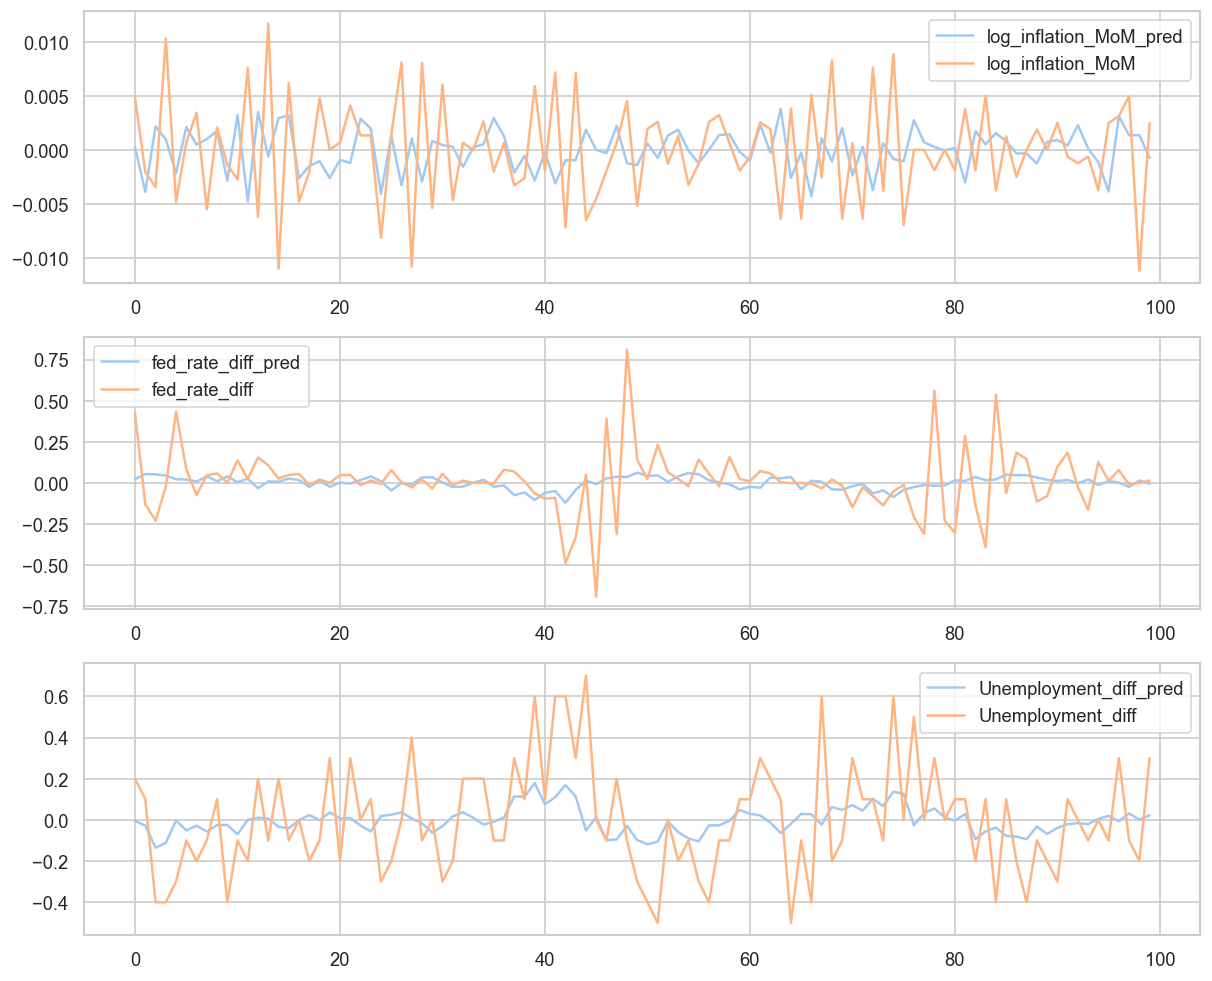

In [81]:
plot_predictions(lstm_model, [0, 100], train_dataloader, transform=True)

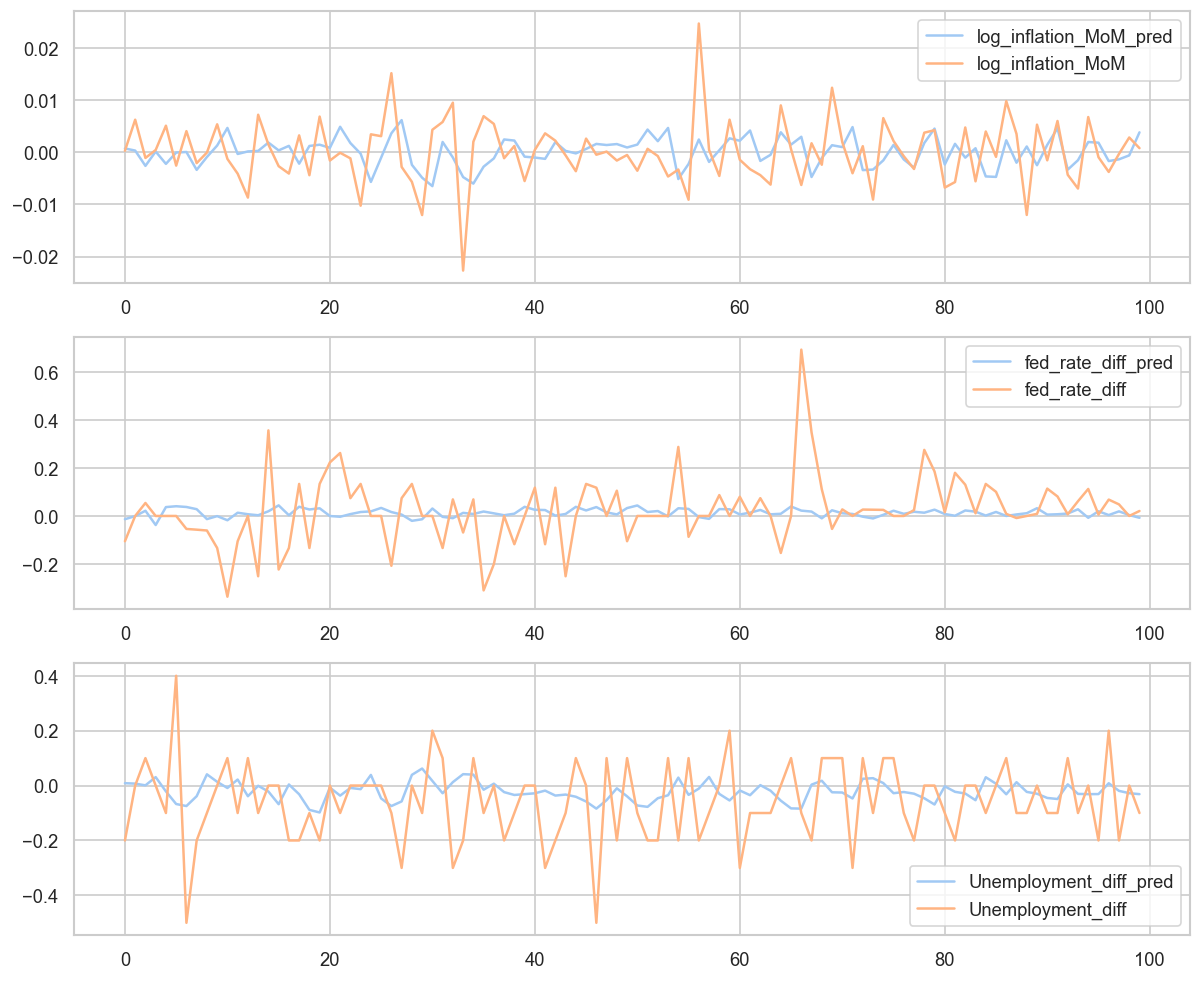

In [82]:
plot_predictions(lstm_model, [0,100], test_dataloader, transform=True)

Text(0.5, 1.0, 'Unemployment_DIFF_pred Residuals')

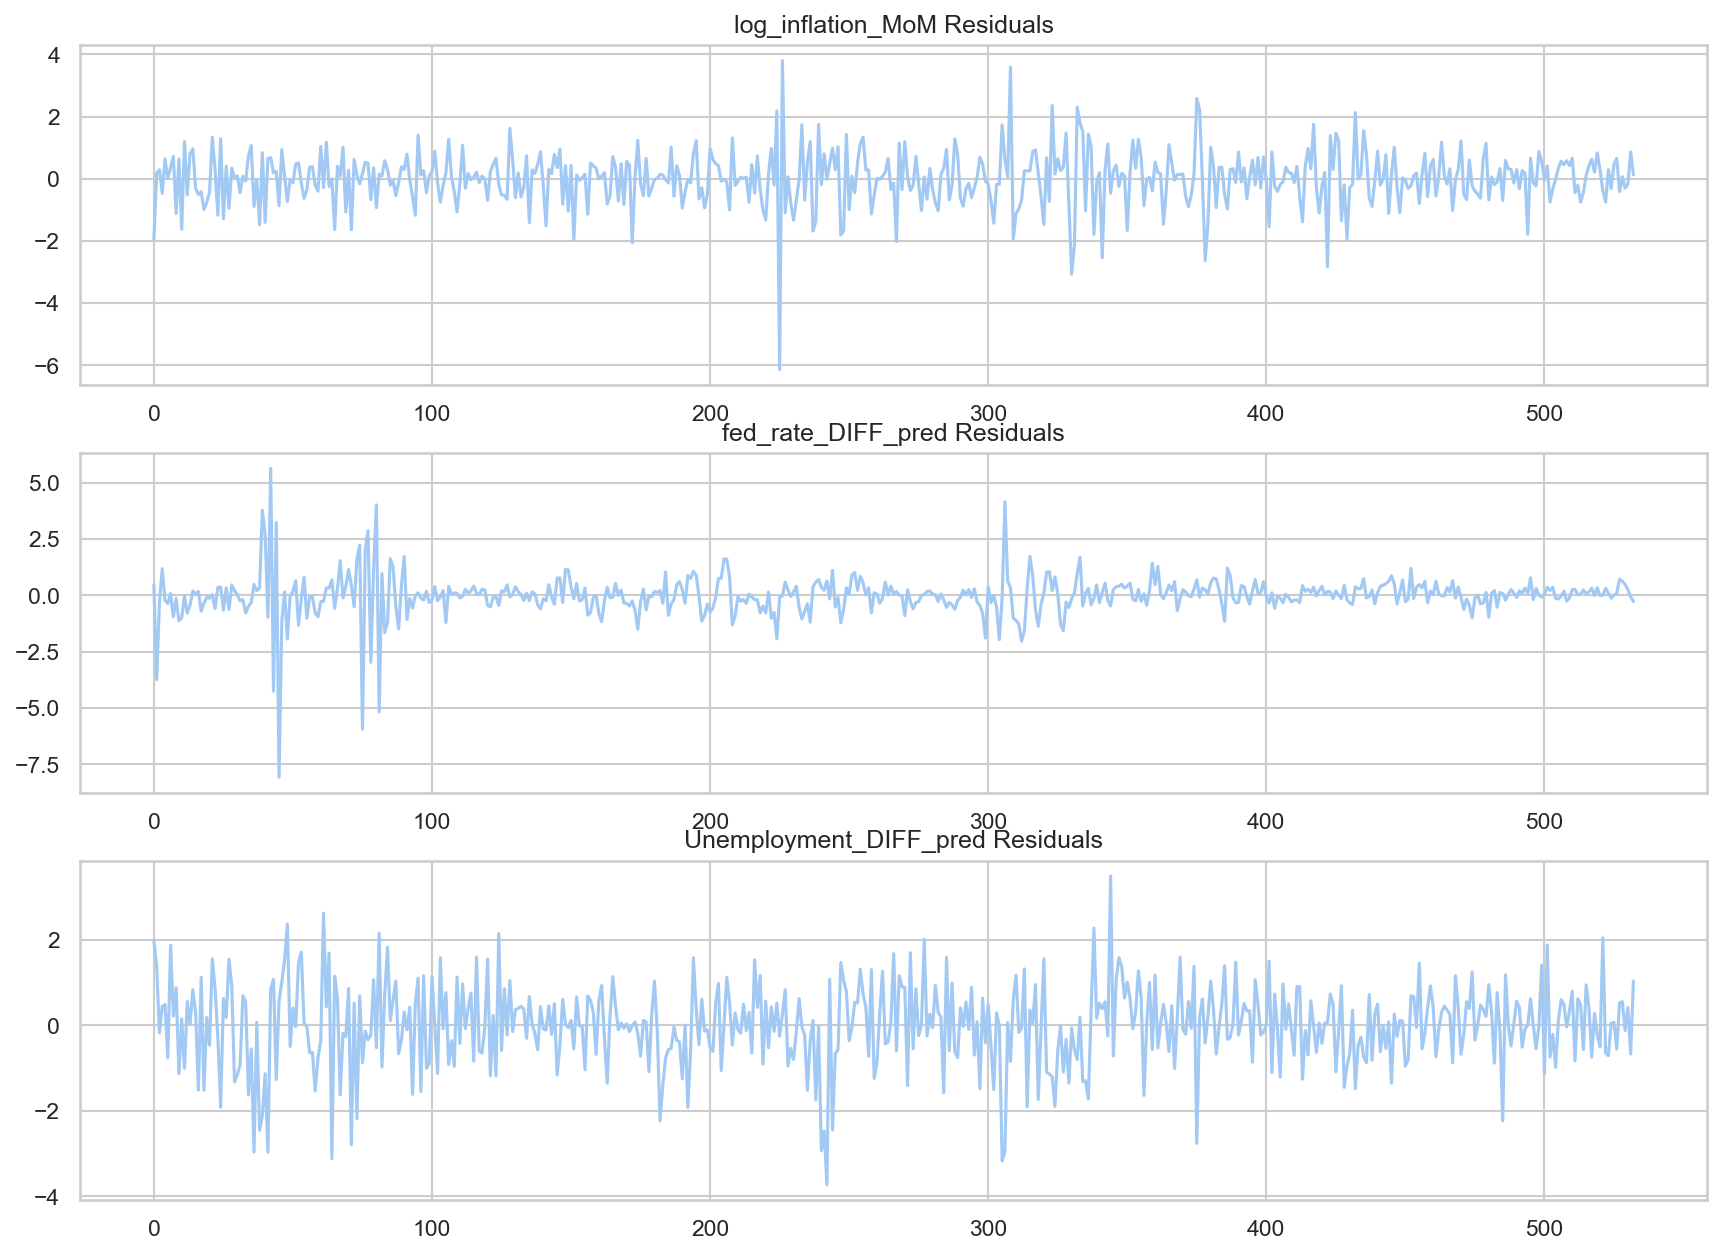

In [83]:
pred, res = get_predictions(lstm_model, train_dataloader,return_residuals=True)
residuals_df = pd.DataFrame(
        res, 
        columns = ["log_inflation_MoM_pred_res", "fed_rate_DIFF_pred_res", "Unemployment_DIFF_pred_res"]
    )

fig, axs = plt.subplots(3, dpi=150, figsize=(14, 10))

residuals_df["log_inflation_MoM_pred_res"].plot(ax=axs[0])
residuals_df["fed_rate_DIFF_pred_res"].plot(ax=axs[1])
residuals_df["Unemployment_DIFF_pred_res"].plot(ax=axs[2])
axs[0].set_title("log_inflation_MoM Residuals")
axs[1].set_title("fed_rate_DIFF_pred Residuals")
axs[2].set_title("Unemployment_DIFF_pred Residuals")

In [100]:
# Get the run
experiment_id = mlflow.get_experiment_by_name("LSTM_training").experiment_id
run = mlflow.search_runs(experiment_id, filter_string="params.scaling='standard'").iloc[0]
run_id = run.run_id

first_version = mlflow.register_model(
    f"runs:/{run_id}/best_model", "LSTMModel"
).version
first_version

Registered model 'LSTMModel' already exists. Creating a new version of this model...
Created version '13' of model 'LSTMModel'.


13

### Tune some Hyperparameters

In [787]:
from optuna.trial import Trial
def objective(trial:Trial):
    params = {
        "hidden_size": trial.suggest_float("hidden_size", 10, 16, step=2),
        "seq_length" : trial.suggest_float("seq_length", 1, 12, step=2),
        "learning_rate": trial.suggest_float("learning_rate", 0.000001, 0.001)
        
    }

    train_dataloader, validation, test_dataloader, full_data_loader, lambda_ = get_data_loaders(
        cutoff_date, validation_cutoff_date, int(params["seq_length"]), transform=True
    )
    
    lstm = LSTM(3, int(params["hidden_size"])).to(device)
    lstm_model = RNN(lstm, "LSTM", 120, train_dataloader, validation_dataloader, 
                     learning_rate=0.0001, device=device, train_data_end_date=cutoff_date)
    lstm_model.train()
    
    loss = lstm_model.best_validation_loss

    return loss

In [ ]:
from optuna.samplers import TPESampler
import optuna

study = optuna.create_study(direction = "minimize", sampler =TPESampler())
study.optimize(objective, n_trials=20)

In [789]:
print(study.best_params)
print(study.best_value)

{'hidden_size': 12.0, 'seq_length': 3.0, 'learning_rate': 0.00028731290480097656}
2.0225421876618355


### Uncomment and run if optuna finds better parameters

In [ ]:
# hidden_size = int(study.best_params['hidden_size'])
# seq_length = int(study.best_params['seq_length'])
# train_dataloader, validation, test_dataloader, full_data_loader, lamba_ = get_data_loaders(cutoff_date, validation_cutoff_date, seq_length, transform=True)

# lstm = LSTM(3, hidden_size).to(device)
# lstm_model = RNN(lstm, "LSTM", 120, train_dataloader, validation_dataloader, 
#                  learning_rate=0.0001, device=device, train_data_end_date=cutoff_date)

# mlflow.set_experiment('LSTM_training')
# # Train LSTM
# lstm_model.train()

In [ ]:
# second_version = mlflow.register_model(
#     f"runs:/{run_id}/best_model", "LSTMModel"
# ).version

# client = mlflow.MlflowClient()
# client.set_registered_model_alias("LSTMModel", "staging", second_version)

In [86]:
# Register scaler
client = mlflow.MlflowClient()

version = mlflow.register_model(
    f"runs:/{run_id}/scaler", "standardscaler"
).version

client.set_registered_model_alias("standardscaler", "production", version)

Registered model 'standardscaler' already exists. Creating a new version of this model...
Created version '5' of model 'standardscaler'.


# Model Evaluation

In [87]:
def forecast_out_of_sample(model, device, seq_length):
    """ Generates raw forecasts with the PyTorch model

    Parameters
    ----------
    X : torch.tensor
      Latest observed data so the model can forecast into the future.

    Returns
    -------
    torch.tensor
    """
    first_data = test_dataloader.dataset.data[-seq_length:, :].to(device)
    forecasts = []
    outputs = []
    for i in range(len(test_dataloader.dataset.data)):
        out = model.predict(first_data)
        new_value = torch.concat(
            [
                first_data[-(seq_length+1):].unsqueeze(dim=0), 
                out[-1].reshape(1,1,3)
            ], 
            dim=1
        )[:, 1:, :]
        
        forecasts.append(new_value[:, -1, :].unsqueeze(dim=0))
        outputs.append(new_value)
        first_data = outputs[-1].squeeze(dim=0)
    return torch.concat(forecasts, dim=1).to(device)

In [138]:
def calculate_performance_metrics(forecasts, dataloader, device):
    """ Calculates the mean squared error and mean absolute error.
    """
    mse_ = mse(forecasts.squeeze(), dataloader.dataset.data.to(device)).item()
    mae_ = mean_absolute_error(forecasts.squeeze().cpu(), test_dataloader.dataset.data.cpu())
    return mse_, mae_

In [140]:
# test LSTM with params 'hidden_size': 12.0, 'seq_length': 3.0, 'learning_rate': 0.0001
# Set first model to staging and test
client.set_registered_model_alias("LSTMModel", "staging", first_version)
model = mlflow.pytorch.load_model(
            model_uri = "models:/LSTMModel@staging"
        )

lstm_model.set_model(model)
forecasts = forecast_out_of_sample(lstm_model, device, 3)

mse_, mae_ = calculate_performance_metrics(forecasts, test_dataloader, device)
print("MSE:", mse_)
print("MAE:", mae_)

MSE: 9.292501778693799
MAE: 1.0998005979219092


In [118]:
def create_production_model(run):
    _, _, _, full_data_loader, lamba_ = get_data_loaders(
        cutoff_date, validation_cutoff_date, seq_length=int(run["params.sequence length"]), transform=True,
    )
    
    if run["params.gradient clipping"] == "None":
        grad_clipping = None
        
    lstm_prod = LSTM(3, int(run["params.hidden size"])).to(device)
    rnn_prod = RNN(
        rnn=lstm_prod,
        model_name="LSTMprod",
        n_epoch=int(run["params.epochs"]),
        learning_rate=float(run["params.learning_rate"]),
        train_loader=full_dataloader,
        gradient_clipping=grad_clipping,
        device=device,
    )
    
    experiment_id = mlflow.get_experiment_by_name("LSTM_training").experiment_id
    run = mlflow.search_runs(experiment_id, filter_string="params.scaling='standard'").iloc[0]
    run_id = run.run_id
    
    version = mlflow.register_model(
        f"runs:/{run_id}/best_model", "LSTMProduction"
    ).version
    client.set_registered_model_alias("LSTMProduction", "production", version)

In [119]:
# Let model procede if performance is satisfactory
if mse_ < 9.31 and mae_ < 1.11:
    create_production_model(run)

Registered model 'LSTMProduction' already exists. Creating a new version of this model...
Created version '5' of model 'LSTMProduction'.


## Forecasts

In [120]:
def generate_latest_prediction(model, seq_length):
    most_recent_diff = pd.DataFrame(
        full_dataloader.dataset.data.cpu().numpy(), 
        columns=[["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]],
        index=data_diff.index
    )
    most_recent_diff = most_recent_diff.iloc[-seq_length:]
    print(most_recent_diff)
    most_recent = data_diff.iloc[-2:][["CPI", "fed_rate", "Unemployment"]]
    yr_ago_cpi = data_diff.iloc[[-12]][["CPI"]]

    # Log transform data so we can add the forecasts to them
    most_recent_logs = most_recent.copy()
    most_recent_logs["CPI"] = boxcox(most_recent_logs["CPI"], lmbda= lambda_)[0]
    most_recent_logs["fed_rate"] = np.exp(np.log(most_recent_logs["fed_rate"]))

    data = torch.tensor(
        scaler.transform(most_recent_diff)
    ).to(device).unsqueeze(dim=0)

    # Untransform forecasts and add them to the latest observation 
    # since the model forecasts the change in the variables.

    prediction = scaler.inverse_transform(
        model.predict(data).cpu().numpy()
    )
    prediction = prediction + (most_recent_logs.iloc[[-1],:].mul({"CPI": 2, "fed_rate":1, 
                                                                  "Unemployment":1}) 
                               - [most_recent_logs.iloc[-2]["CPI"].item(), 0, 0])
    prediction.index = [most_recent_logs.index[-1] + pd.DateOffset(months=1)]
    
    # undo logs
    prediction["CPI"] =(prediction["CPI"]*(lambda_) + 1)**(1/lambda_)
    prediction["fed_rate"] = prediction["fed_rate"]

    return prediction


def round_predictions(predictions):
    predictions["fed_rate"] = round(predictions["fed_rate"], 2)
    predictions["CPI"] = round(predictions["CPI"], 3)
    predictions["Unemployment"] = round(predictions["Unemployment"], 1)


def calculate_inflation(predictions, mode="both"):
    most_recent = data_diff.iloc[[-1]][["CPI", "fed_rate", "Unemployment"]]
    yr_ago_cpi = data_diff.iloc[[-12]][["CPI"]]
    # MoM  inflation
    inflation_mom = ((predictions["CPI"].item() - most_recent["CPI"].item()) 
                     / most_recent["CPI"].item())*100
    # YoY Inflation
    inflation_yoy = ((predictions["CPI"].item() - yr_ago_cpi["CPI"].item()) 
                     / yr_ago_cpi["CPI"].item())*100
    if mode == "yoy":
        return inflation_yoy
    elif mode == "mom":
        return inflation_mom
    else:
        return inflation_mom, inflation_yoy

month = (data_diff.iloc[[-1]].index + pd.DateOffset(months=1))\
    .strftime("%B").item()


In [126]:
# Look at some forecasts
model_name = "LSTMProduction@production"
model = mlflow.pytorch.load_model(
            model_uri = f"models:/{model_name}"
        )
lstm_model.set_model(model)
prediction = generate_latest_prediction(lstm_model, 3)
round_predictions(prediction)
prediction_month = prediction.index.get_level_values(0).strftime("%B").item()
prediction["fed_rate"] = round(prediction["fed_rate"], 2)
print(f"{month} forecasts:\n", prediction)
inflation_mom, inflation_yoy = calculate_inflation(prediction)
print(f"MoM inflation rate: {inflation_mom}%")
print(f"YoY inflation rate: {inflation_yoy}%")

           log_inflation_MoM fed_rate_diff Unemployment_diff
2024-03-01         -0.356221      -0.03298         -0.488560
2024-04-01         -0.363689      -0.03298          0.518625
2024-05-01         -1.714619      -0.03298          0.518625
June forecasts:
                 CPI  fed_rate  Unemployment
2024-06-01  313.276      5.34           4.0
MoM inflation rate: 0.016282225237445196%
YoY inflation rate: 3.0502988457350835%
